# Produce all the plots that will be included in the presentation slides and the final report 

In [1]:
# load necessary libraries
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import geopandas as gpd
import os

In [2]:
# load all datasets that have been previously cleaned and saved 
tg_2020 = pd.read_csv('clean_data/tg_2020.csv')
tg_2022 = pd.read_csv('clean_data/tg_2022.csv')
gt_2020 = pd.read_csv('clean_data/gt_2020.csv')
gt_2022 = pd.read_csv('clean_data/gt_2022.csv')
yt_2020 = pd.read_csv('clean_data/yt_2020.csv')
yt_2022 = pd.read_csv('clean_data/yt_2022.csv')
news = pd.read_csv('news_data/keywords.csv')
off_2020 = pd.read_csv('clean_data/off_2020.csv')
off_2022 = pd.read_csv('clean_data/off_2022.csv')
mae_in_sample= pd.read_csv('in_sample_val/metrics.csv')
mae_out_sample = pd.read_csv('out_sample_val/metrics.csv')
mx_states = gpd.read_file('files/states.geojson')
pca_social = pd.read_csv('PCA/score.csv')

# YouTube

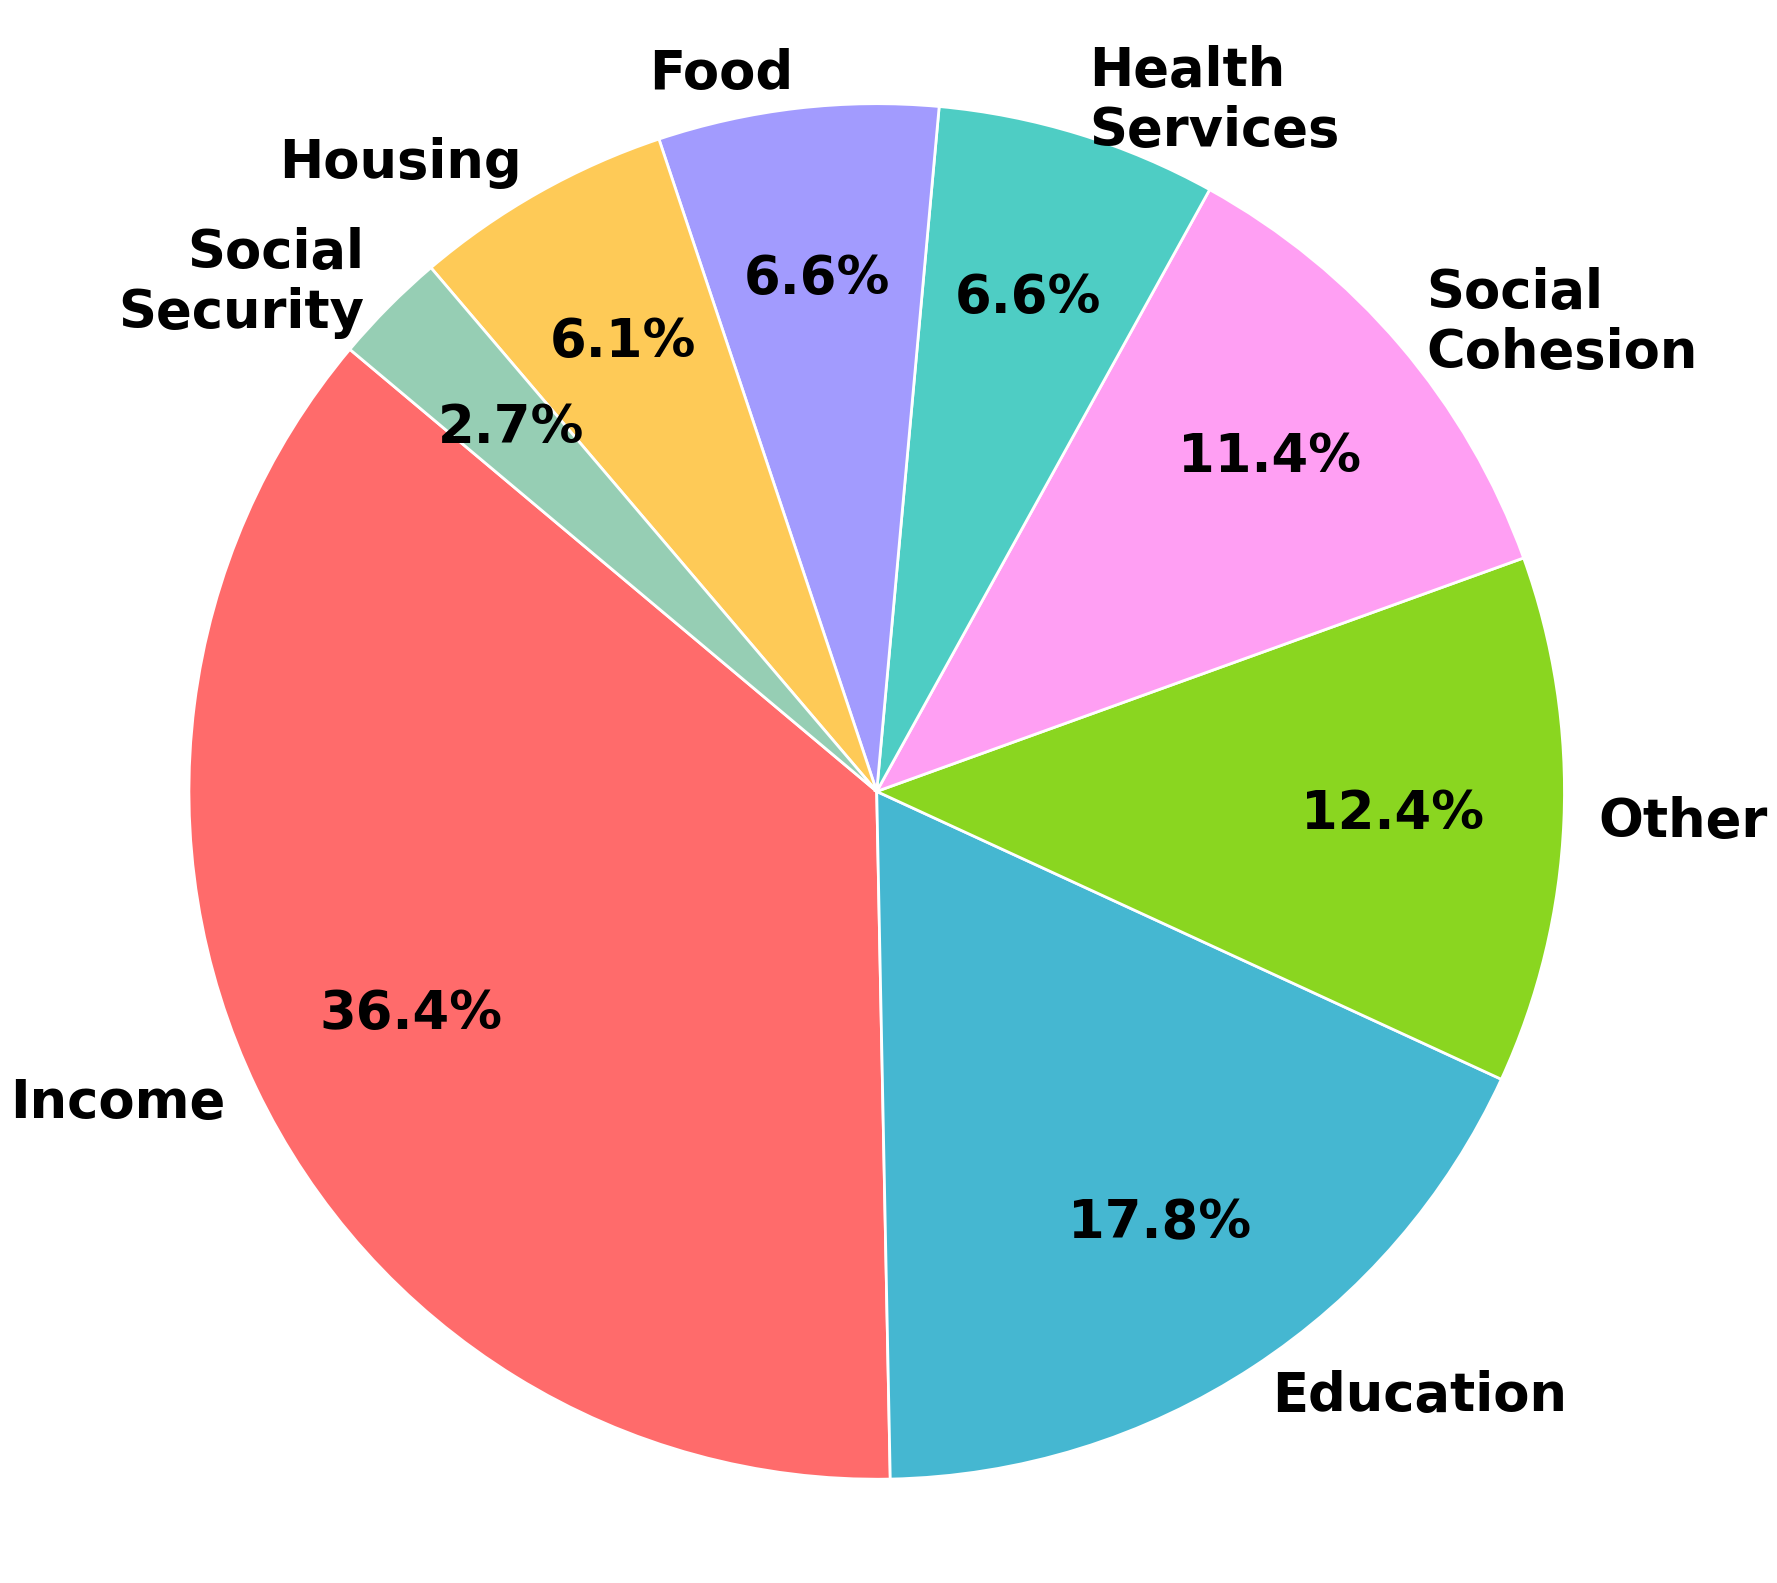

In [62]:
# Color mapping for each poverty dimension in the pie chart 
dimension_colors = {
    'Income': '#FF6B6B',
    'Health\nServices': '#4ECDC4',
    'Education': '#45B7D1',
    'Social\nSecurity': '#96CEB4',
    'Housing': '#FECA57',
    'Food': '#A29BFE',
    'Social\nCohesion': '#FF9FF3', 
    'Other': "#8AD620"}

# Mapping from column names in the dataset to the display labels used in the pie chart 
column_mapping_pie = {
    'access_to_food_pct_yt': 'Food',
    'access_to_health_services_pct_yt': 'Health\nServices',
    'access_to_social_security_pct_yt': 'Social\nSecurity',
    'educational_lag_pct_yt': 'Education',
    'housing_pct_yt': 'Housing',
    'income_pct_yt': 'Income',
    'social_cohesion_pct_yt': 'Social\nCohesion',
    'other_pct_yt': 'Other'}

# create a pie chart showing the average percentage of YouTube comments associated with each poverty dimension
def create_comment_distribution_pie(yt_2022):
    fig, ax = plt.subplots(figsize=(18, 18))  

    avg_percentages_dict = {}
    # compute the average value (in percentage) for each dimension across all states
    for col, dim_name in column_mapping_pie.items():
        if col in yt_2022.columns:
            avg_percentages_dict[dim_name] = yt_2022[col].mean() * 100

    # sort dimensions by average percentage in descending order
    sorted_dimensions = sorted(avg_percentages_dict.items(), key=lambda x: x[1], reverse=True)
    dimensions = [item[0] for item in sorted_dimensions]
    avg_percentages = [item[1] for item in sorted_dimensions]
    colors = [dimension_colors[dim] for dim in dimensions]

    # create pie chart with custom formatting 
    wedges, texts, autotexts = ax.pie(
        avg_percentages, 
        labels=dimensions, 
        colors=colors, 
        autopct='%1.1f%%',         # Show percentages on wedges
        startangle=140,            # Rotate the chart for better visual balance
        textprops={'fontsize': 36, 'fontweight': 'bold'},  
        pctdistance=0.75,          # Position of the percentage labels inside slices
        labeldistance=1.05,        # Distance of labels from the center
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},  # Slice border styling
        radius=1.1                 # Slightly increase the radius for better spacing
    )

    # customize percentage labels
    for autotext in autotexts:
        autotext.set_color('black')  
        autotext.set_fontsize(38)   
        autotext.set_fontweight('bold')
    
    # customize category labels
    for text in texts:
        text.set_fontsize(38)      
        text.set_fontweight('bold')

    plt.tight_layout() 
    return fig

yt_pie = create_comment_distribution_pie(yt_2022)
yt_pie.savefig('plots/yt_pie.png', bbox_inches='tight', dpi=300)

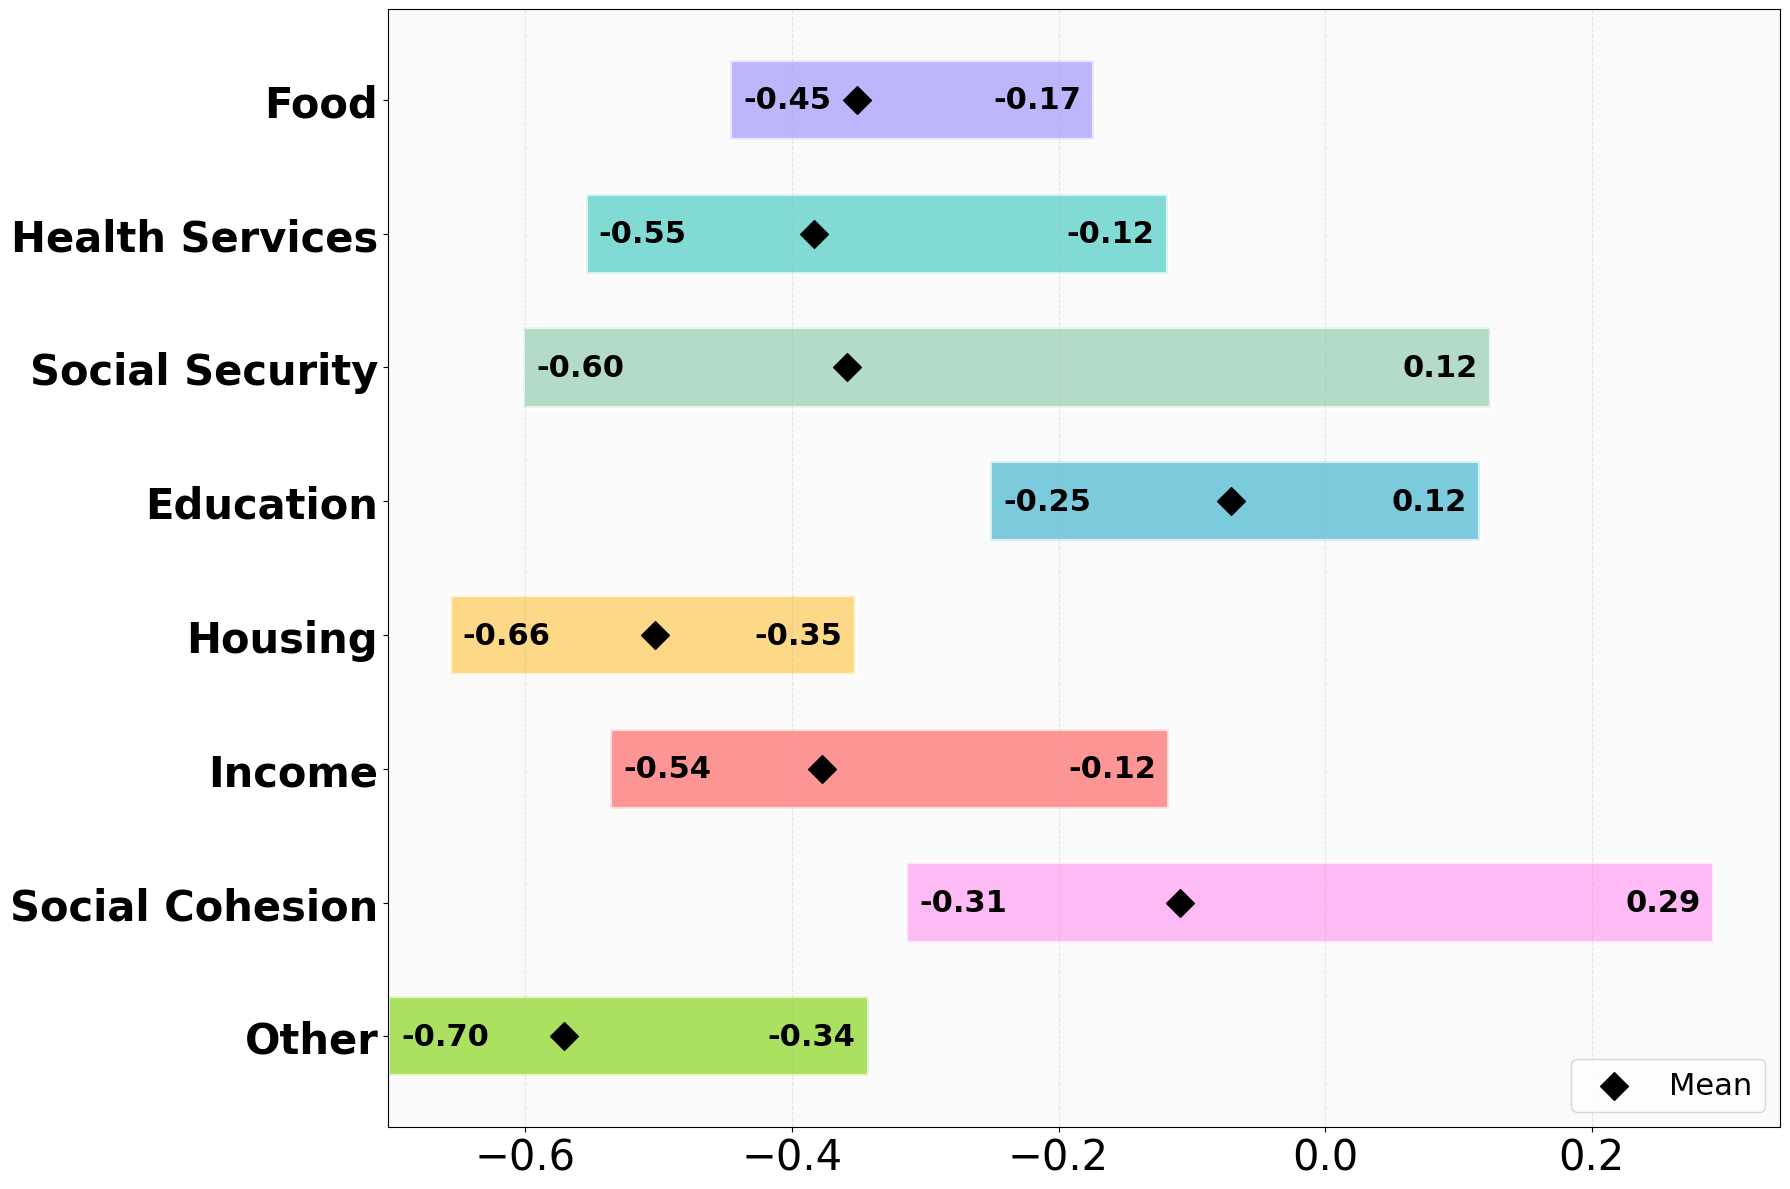

In [64]:
# Mapping from standard labels to their internal \n-based labels used for color referencing
label_mapping = {
    'Income': 'Income',
    'Health Services': 'Health\nServices',
    'Education': 'Education',
    'Social Security': 'Social\nSecurity',
    'Housing': 'Housing',
    'Food': 'Food',
    'Social Cohesion': 'Social\nCohesion',
    'Other': 'Other'}

# plot sentiment range for each poverty dimension with mean marker
def create_sentiment_range_plot(yt_2022):
    fig, ax = plt.subplots(figsize=(18, 12)) 

    # select sentiment-related columns
    sentiment_cols = [col for col in yt_2022.columns if 'avg_sentiment' in col]

    # map column names to their corresponding dimension labels
    col_to_dimension = {
        'other_avg_sentiment': 'Other',
        'access_to_food_avg_sentiment': 'Food',
        'access_to_health_services_avg_sentiment': 'Health Services',
        'access_to_social_security_avg_sentiment': 'Social Security',
        'educational_lag_avg_sentiment': 'Education',
        'housing_avg_sentiment': 'Housing',
        'income_avg_sentiment': 'Income',
        'social_cohesion_avg_sentiment': 'Social Cohesion'}

    dimensions = []
    colors = []
    sentiment_ranges = []

    # extract dimension name, corresponding color, and min-max sentiment range
    for col in sentiment_cols:
        clean_col = col.replace('_yt', '')  
        if clean_col in col_to_dimension:
            dim_name = col_to_dimension[clean_col]
            label_color = label_mapping[dim_name]  
            dimensions.append(dim_name)
            colors.append(dimension_colors[label_color])
            sentiment_ranges.append([yt_2022[col].min(), yt_2022[col].max()])

    # ensure "Other" appears last in the chart
    if 'Other' in dimensions:
        idx = dimensions.index('Other')
        dim = dimensions.pop(idx)
        col = colors.pop(idx)
        rng = sentiment_ranges.pop(idx)
        dimensions.append(dim)
        colors.append(col)
        sentiment_ranges.append(rng)

    # draw horizontal bars for sentiment ranges with mean marker and value labels
    for i, (dim, color, (min_val, max_val)) in enumerate(zip(dimensions, colors, sentiment_ranges)):
        ax.barh(
            i, max_val - min_val, left=min_val, color=color, alpha=0.7,
            height=0.6, edgecolor='white', linewidth=3)

        # compute and plot the mean sentiment as a diamond marker
        mean_val = yt_2022[
            [col for col in yt_2022.columns if dim.lower().replace(' ', '_') in col and 'avg_sentiment' in col][0]
        ].mean()

        ax.scatter(mean_val, i, color='black', s=200, zorder=5, marker='D')

        # display min and max sentiment values as text on each bar
        ax.text(min_val + 0.01, i, f'{min_val:.2f}', ha='left', va='center',
                fontsize=22, fontweight='bold', color='black')
        ax.text(max_val - 0.01, i, f'{max_val:.2f}', ha='right', va='center',
                fontsize=22, fontweight='bold', color='black')

    # configure axis
    ax.set_yticks(range(len(dimensions)))
    ax.set_yticklabels(dimensions, fontsize=30, fontweight='bold')
    ax.invert_yaxis()  # Invert y-axis to have 'other' at the bottom - as with the control above was still first 
    ax.tick_params(axis='x', labelsize=30)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_facecolor('#fafafa')  

    # add legend for the mean marker
    ax.scatter([], [], color='black', s=200, marker='D', label='Mean')
    ax.legend(loc='lower right', fontsize=22)

    plt.tight_layout()
    return fig

yt_sent = create_sentiment_range_plot(yt_2022)
yt_sent.savefig('plots/yt_sentiment.png', bbox_inches='tight', dpi=300)

# Telegram

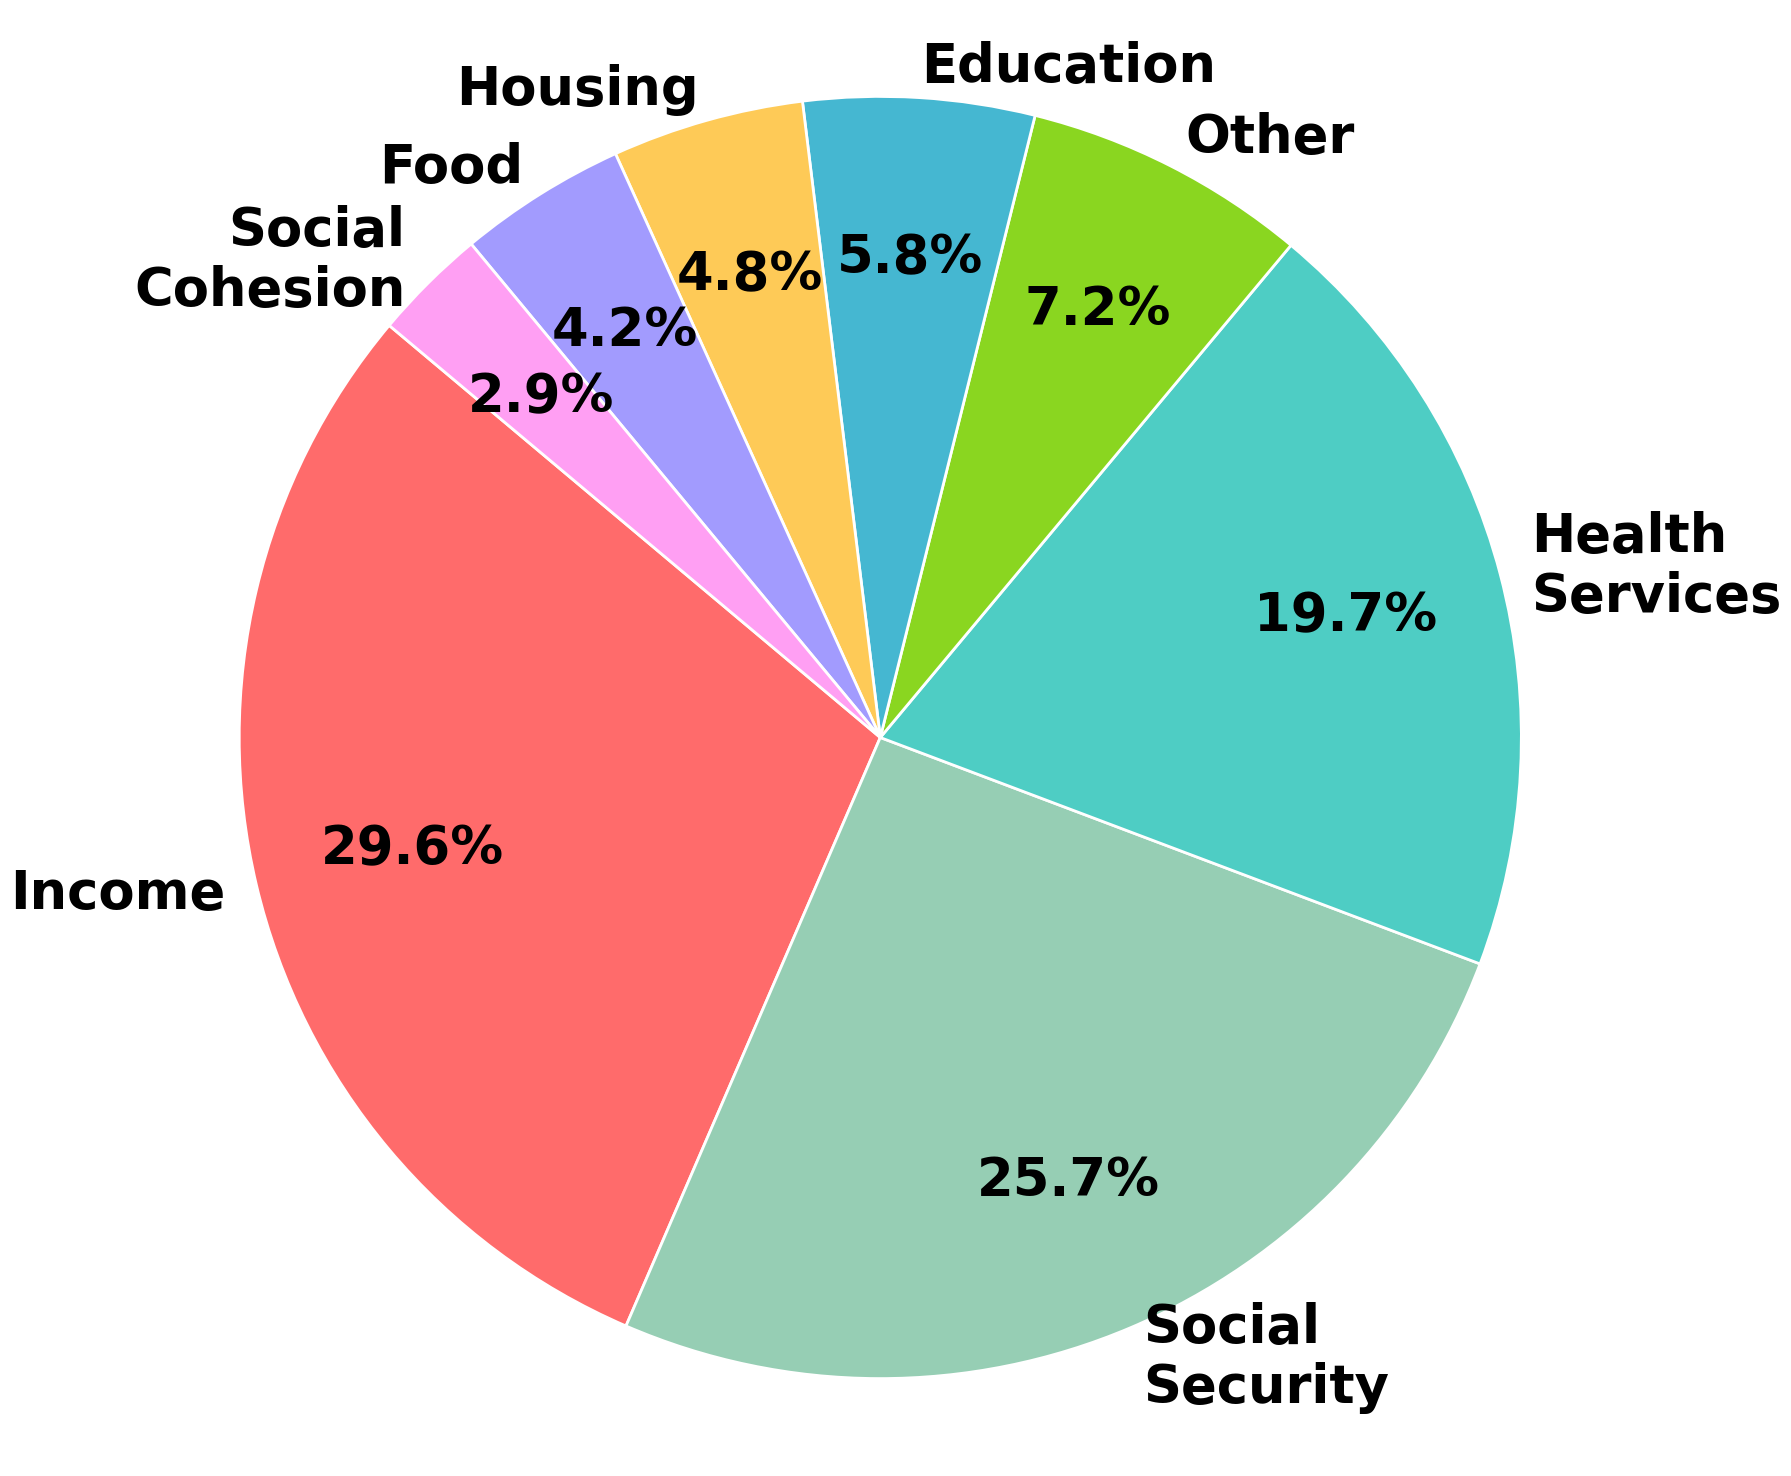

In [65]:
# mapping from Telegram-specific column names to pie chart display labels 
column_mapping_tg = {
    'access_to_food_pct_tg': 'Food',
    'access_to_health_services_pct_tg': 'Health\nServices',
    'access_to_social_security_pct_tg': 'Social\nSecurity',
    'educational_lag_pct_tg': 'Education',
    'housing_pct_tg': 'Housing',
    'income_pct_tg': 'Income',
    'social_cohesion_pct_tg': 'Social\nCohesion',
    'other_pct_tg': 'Other'}

# create a pie chart showing average share of Telegram comments by poverty dimension
def create_comment_distribution_pie_tg(tg_2022):
    fig, ax = plt.subplots(figsize=(18, 18))  

    # compute the mean value for each dimension
    avg_percentages_dict = {
        dim_name: tg_2022[col].mean() * 100
        for col, dim_name in column_mapping_tg.items()
        if col in tg_2022.columns and not np.isnan(tg_2022[col].mean())}

    # sort dimensions in descending order 
    sorted_dimensions = sorted(avg_percentages_dict.items(), key=lambda x: x[1], reverse=True)
    dimensions = [item[0] for item in sorted_dimensions]
    avg_percentages = [item[1] for item in sorted_dimensions]
    colors = [dimension_colors[dim] for dim in dimensions]

    # create the pie chart with customized styling
    wedges, texts, autotexts = ax.pie(
        avg_percentages,
        labels=dimensions,
        colors=colors,
        autopct='%1.1f%%',                  # Show percentages
        startangle=140,                     # Rotate pie for layout balance
        textprops={'fontsize': 36, 'fontweight': 'bold'},  # Font style for labels
        pctdistance=0.75,                   # Position of percentage labels
        labeldistance=1.05,                 # Distance of labels from center
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},  # White border for separation
        radius=1.1                          # Slightly enlarged radius
    )
    
    # format percentage labels 
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(38)
        autotext.set_fontweight('bold')

    # format category labels 
    for text in texts:
        text.set_fontsize(38)
        text.set_fontweight('bold')

    plt.tight_layout()  
    return fig

tg = create_comment_distribution_pie_tg(tg_2022)
tg.savefig('plots/tg_pie.png', dpi=300, bbox_inches='tight')

# Google Trends 

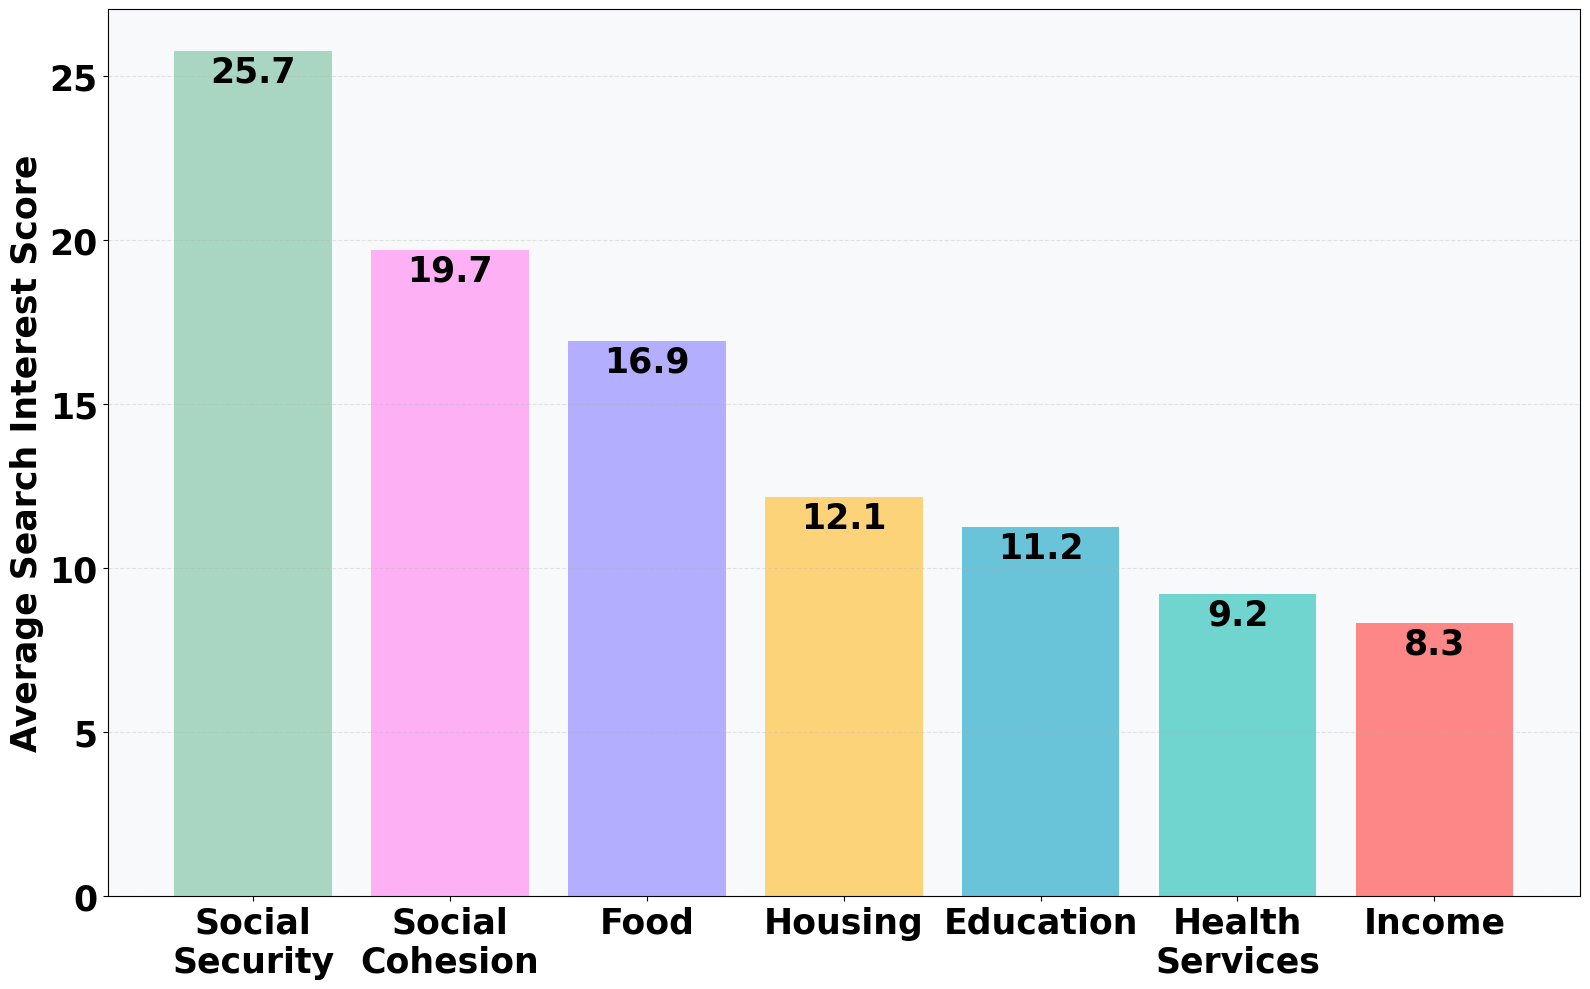

In [66]:
# re-define colors as in google trends we don't have the 'Other' dimension
dimension_colors = {
    'Income': '#FF6B6B',
    'Health Services': '#4ECDC4',
    'Education': '#45B7D1',
    'Social Security': '#96CEB4',
    'Housing': '#FECA57',
    'Food': '#A29BFE',
    'Social Cohesion': '#FF9FF3'}

# rename columns to match dimension names
def rename_gt_columns(df):
    column_mapping = {
        'income_gt': 'Income',
        'health_gt': 'Health Services',
        'educational_lag': 'Education',
        'social_gt': 'Social Security',
        'food_gt': 'Food',
        'housing_gt': 'Housing',
        'cohesion_gt': 'Social Cohesion'}
    return df.rename(columns=column_mapping)

# create a bar plot showing the average interest in each dimension
def create_gt_average_interest(df):
    df = rename_gt_columns(df)
    all_dimensions = list(dimension_colors.keys())
    available = [d for d in all_dimensions if d in df.columns]

    avg_interest = df[available].mean().sort_values(ascending=False)

    dimensions = avg_interest.index.values
    values = avg_interest.values
    x = np.arange(len(dimensions))
    bar_colors = [dimension_colors[dim] for dim in dimensions]

    # divide the labels with spaces into two lines
    formatted_labels = []
    for d in dimensions:
        if ' ' in d:
            parts = d.split()
            d = parts[0] + '\n' + ' '.join(parts[1:])
        formatted_labels.append(d)

    fig, ax = plt.subplots(figsize=(16, 10), facecolor='white')
    bars = ax.bar(x, values, color=bar_colors, alpha=0.8)

    ax.set_facecolor('#f8f9fa')

    # put values on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height - 0.1),
                    ha='center', va='top',
                    fontweight='bold', fontsize=25, color='black')

    ax.set_ylabel('Average Search Interest Score', fontsize=25, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(formatted_labels, rotation=0, ha='center', fontsize=25, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=25)

    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    return fig

fig_gt = create_gt_average_interest(gt_2022)
fig_gt.savefig('plots/gt_barplot.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', transparent=True)

# News Outlets 

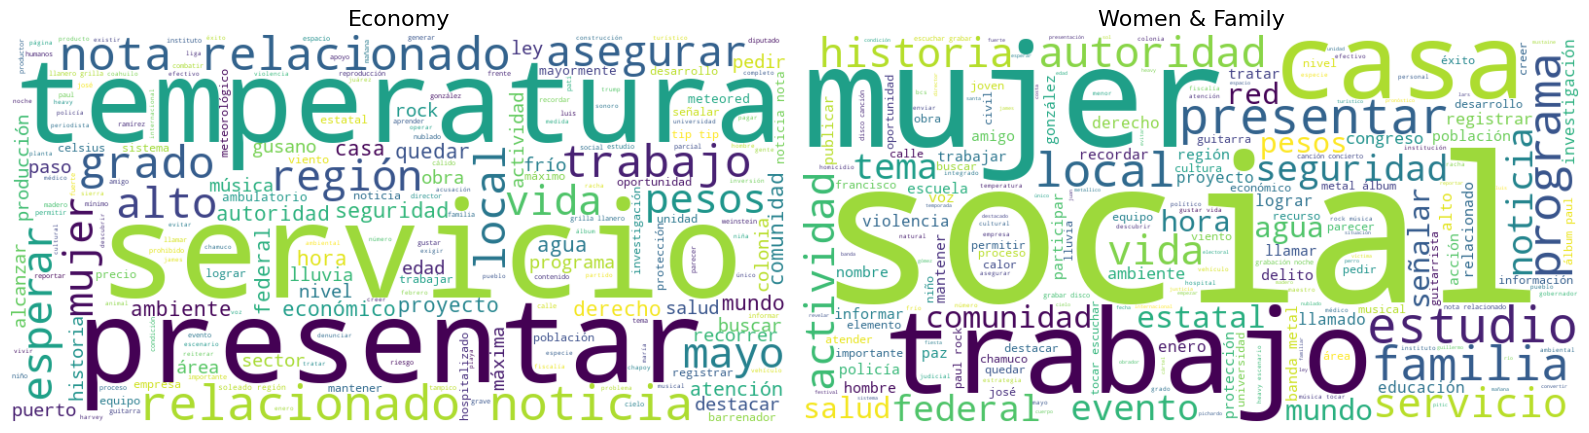

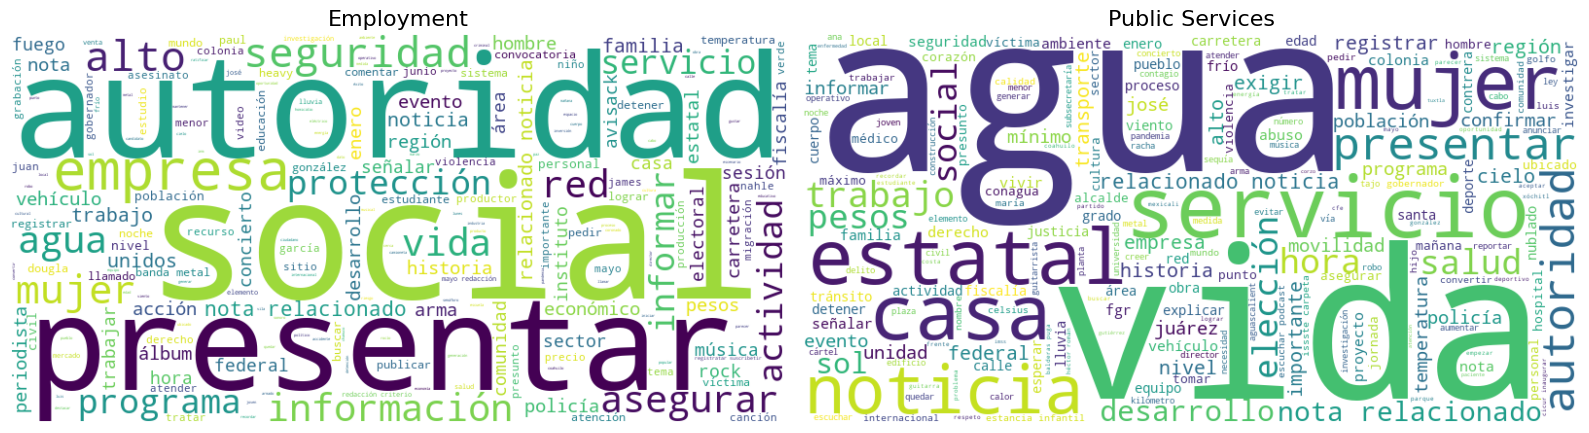

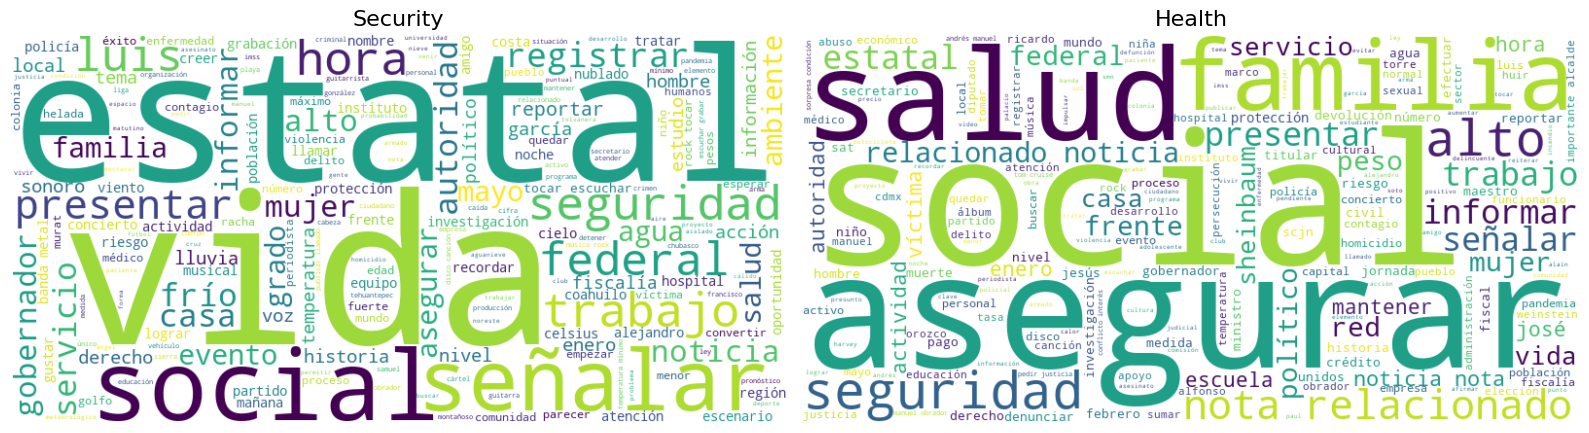

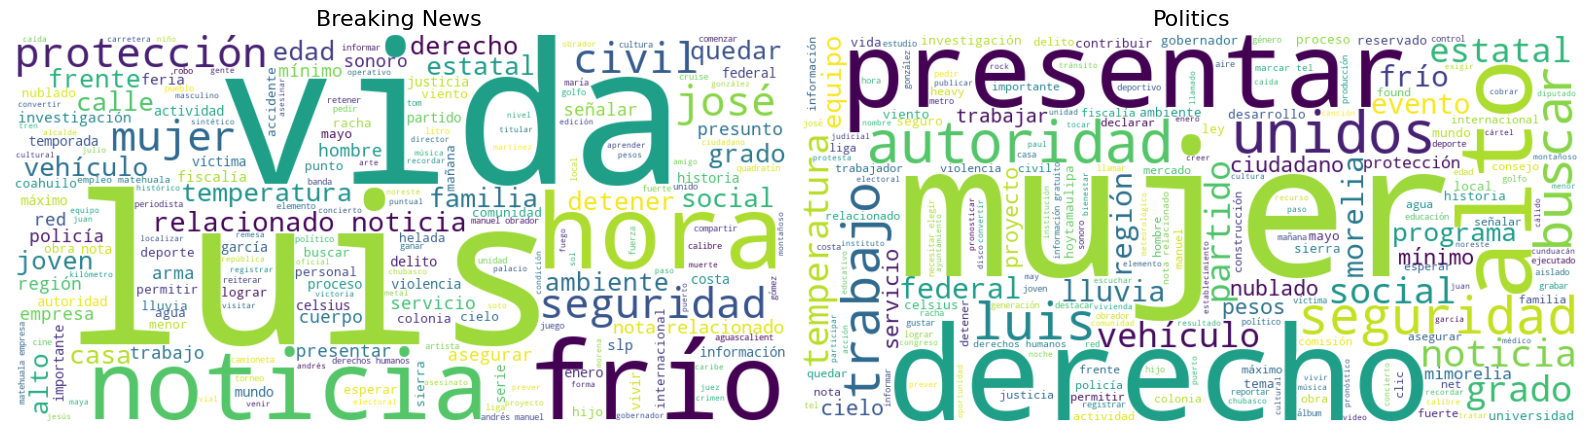

In [67]:
# map topics to their names 
topic_name_mapping = {
    "Topic_0": "Economy",
    "Topic_1": "Women & Family",
    "Topic_2": "Employment",
    "Topic_3": "Public Services",
    "Topic_4": "Security",
    "Topic_5": "Health",
    "Topic_6": "Breaking News",
    "Topic_7": "Politics"}

topic_cols = [col for col in news.columns if col.startswith("Topic_")]

for i in range(0, len(topic_cols), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for j in range(2):
        if i + j < len(topic_cols):
            col = topic_cols[i + j]
            text = ' '.join(news[col].dropna().tolist())
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  colormap='viridis', random_state=123).generate(text)
            axes[j].imshow(wordcloud, interpolation='bilinear')
            axes[j].axis('off')
            title = topic_name_mapping.get(col, col) 
            axes[j].set_title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/news_wordcloud_{i//2 + 1}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Official Statistics 

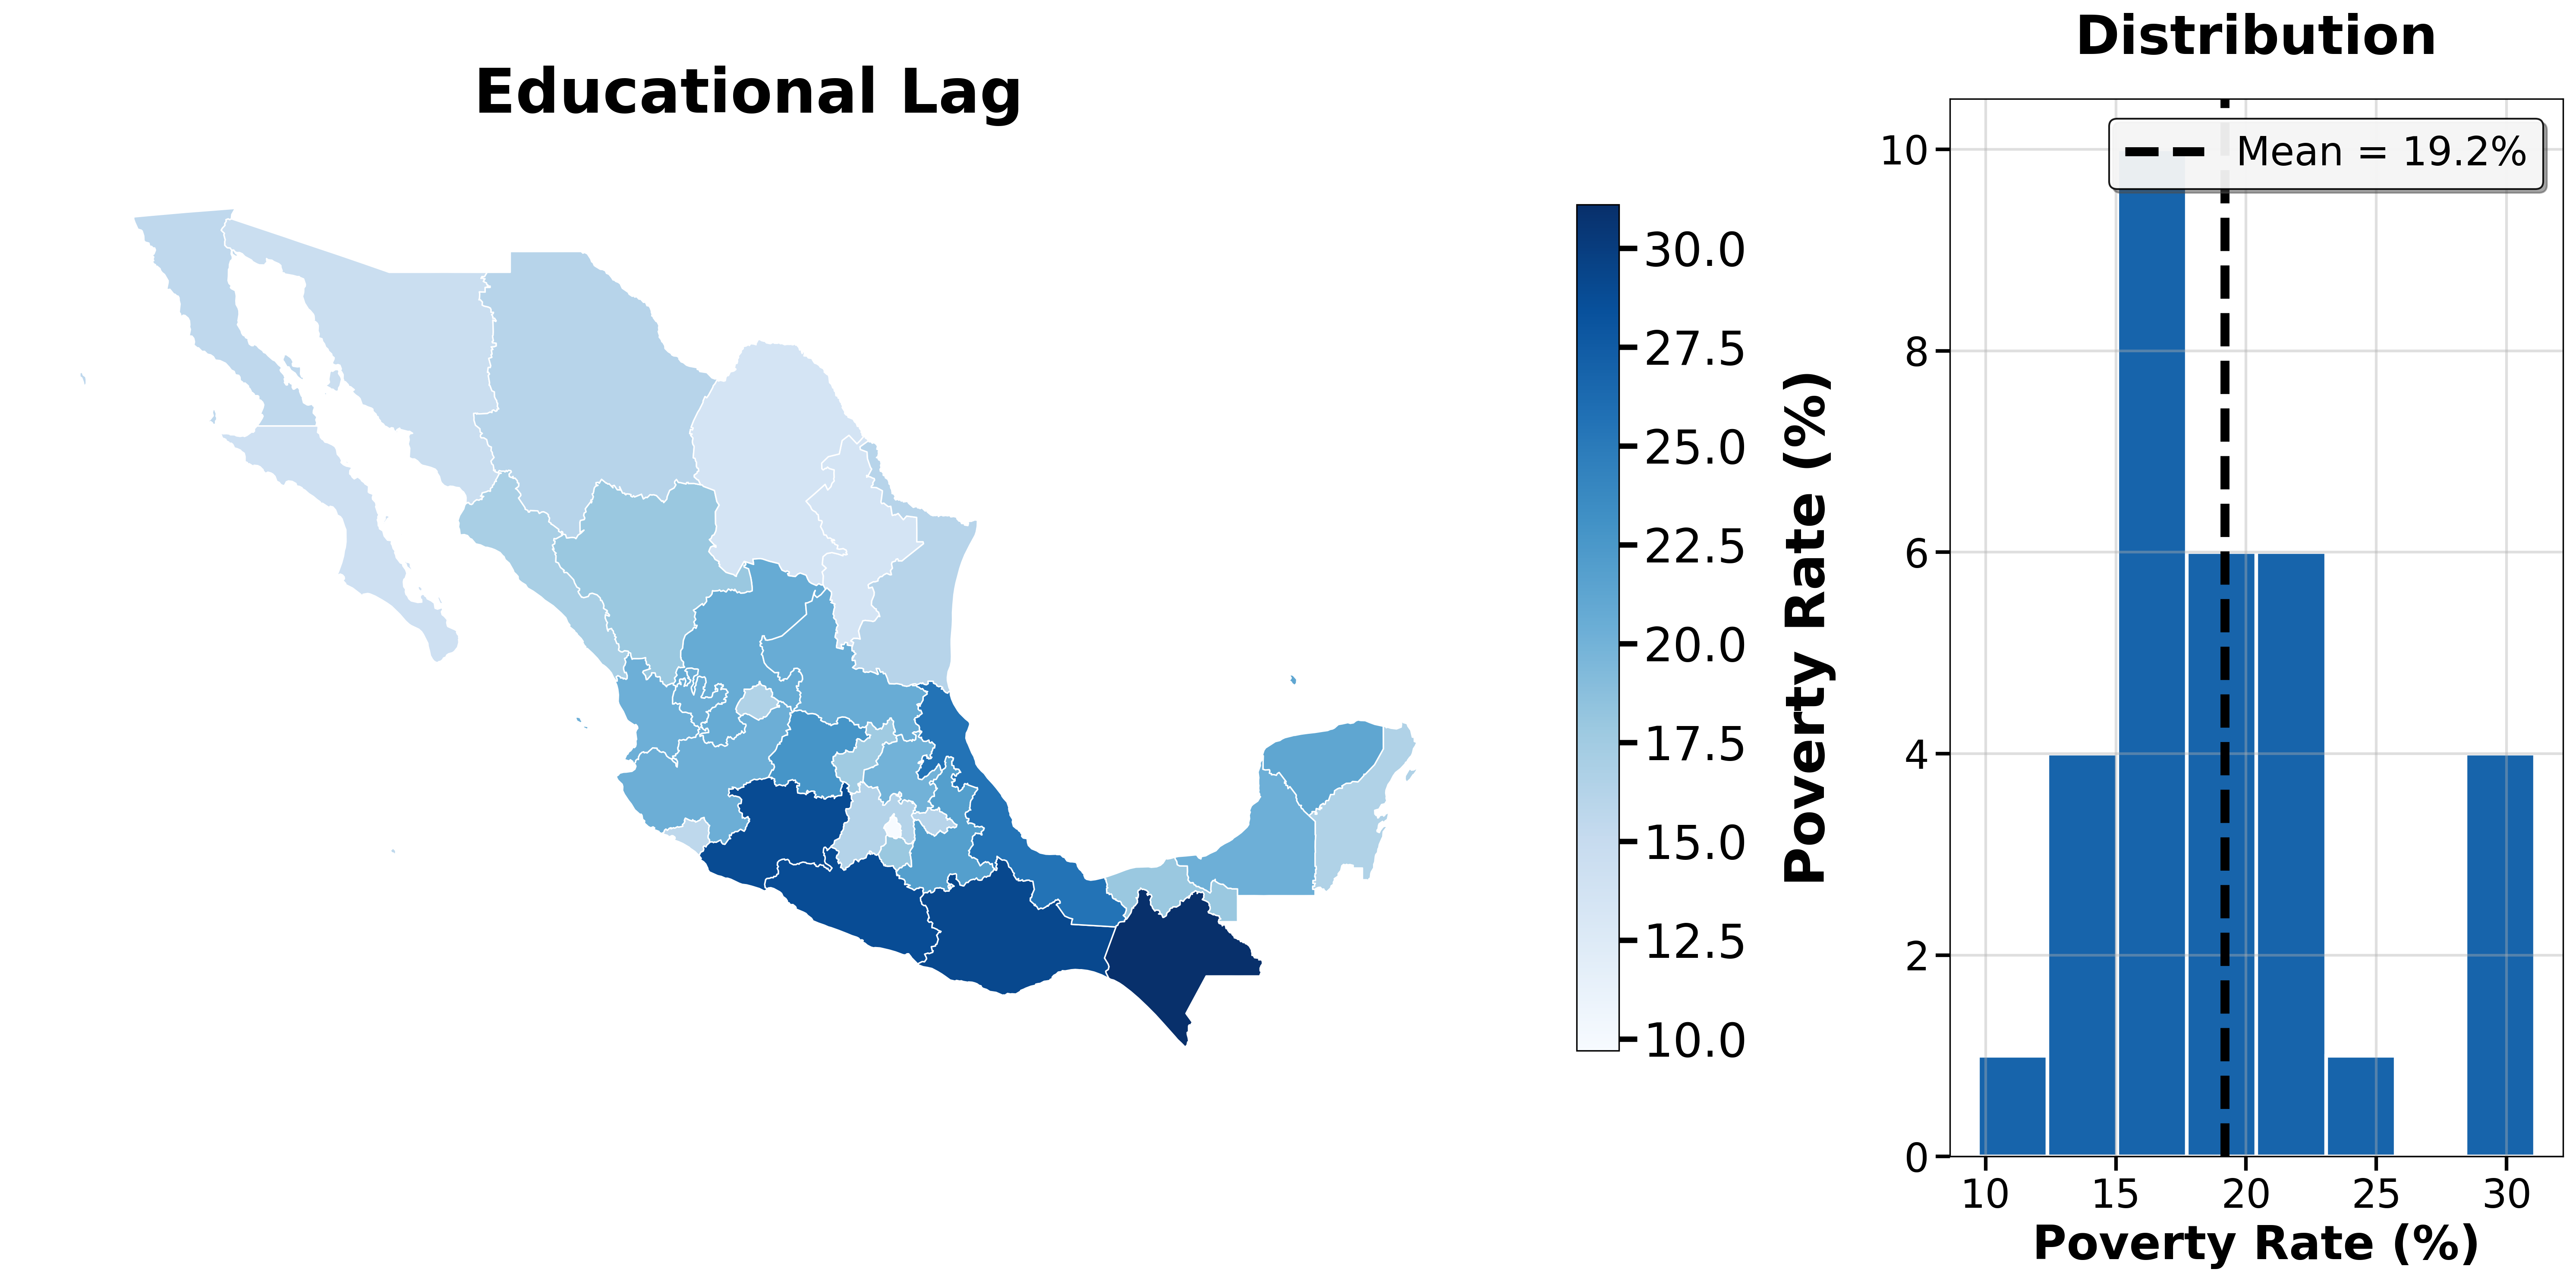

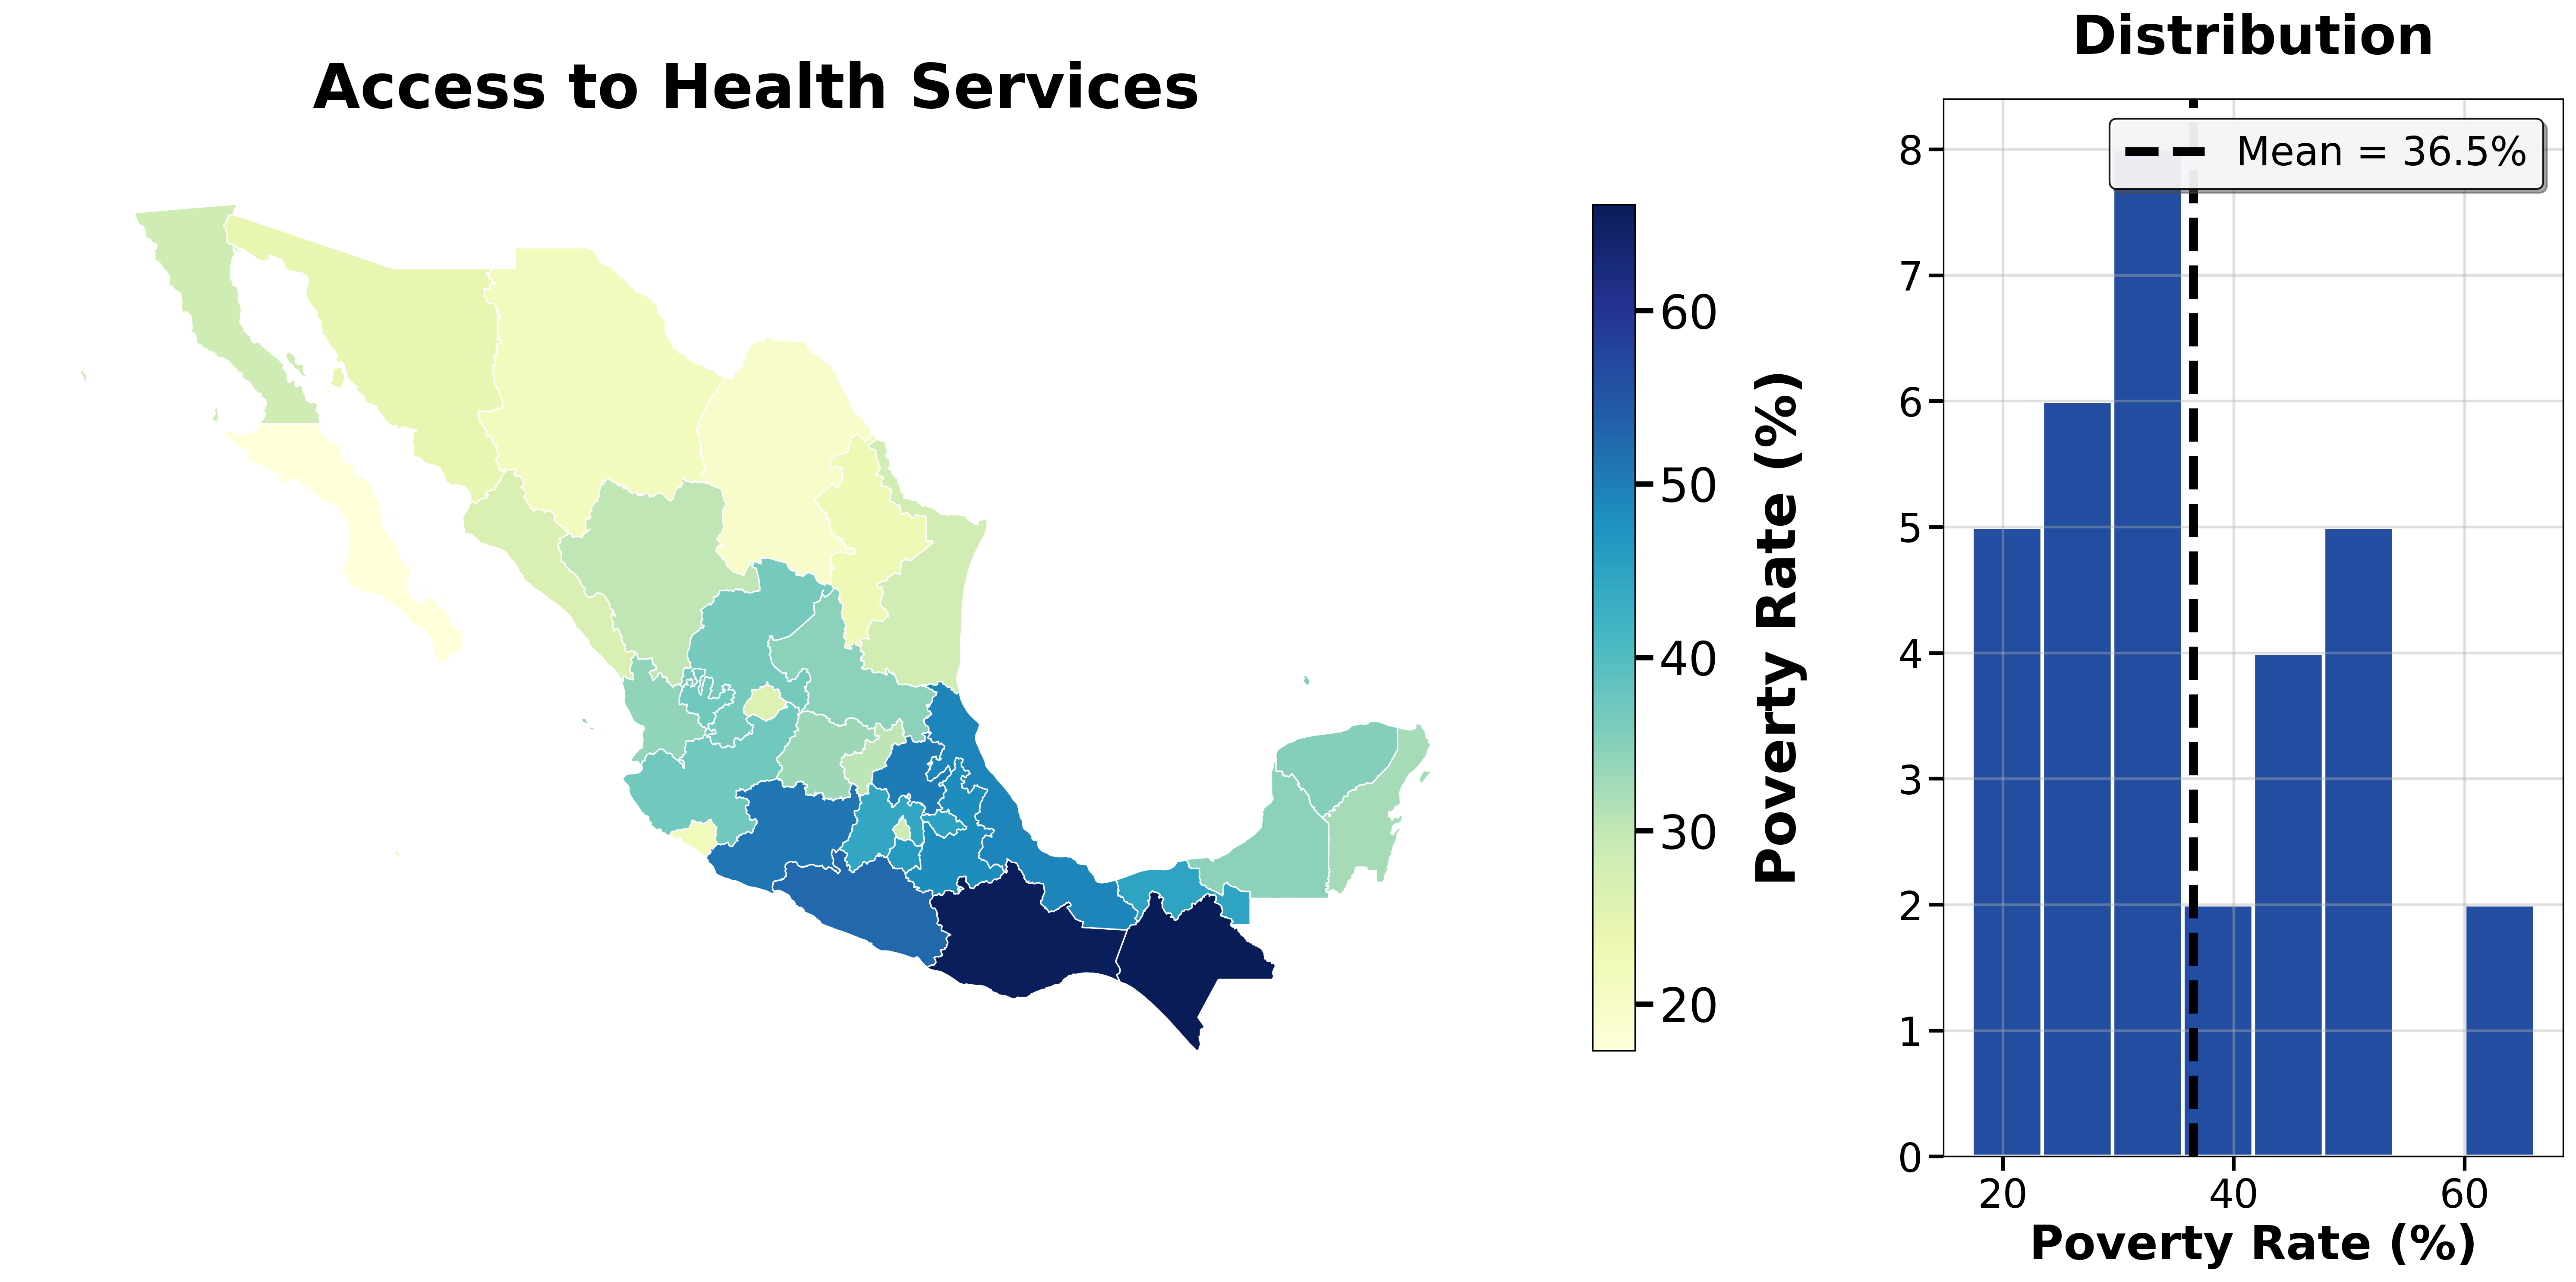

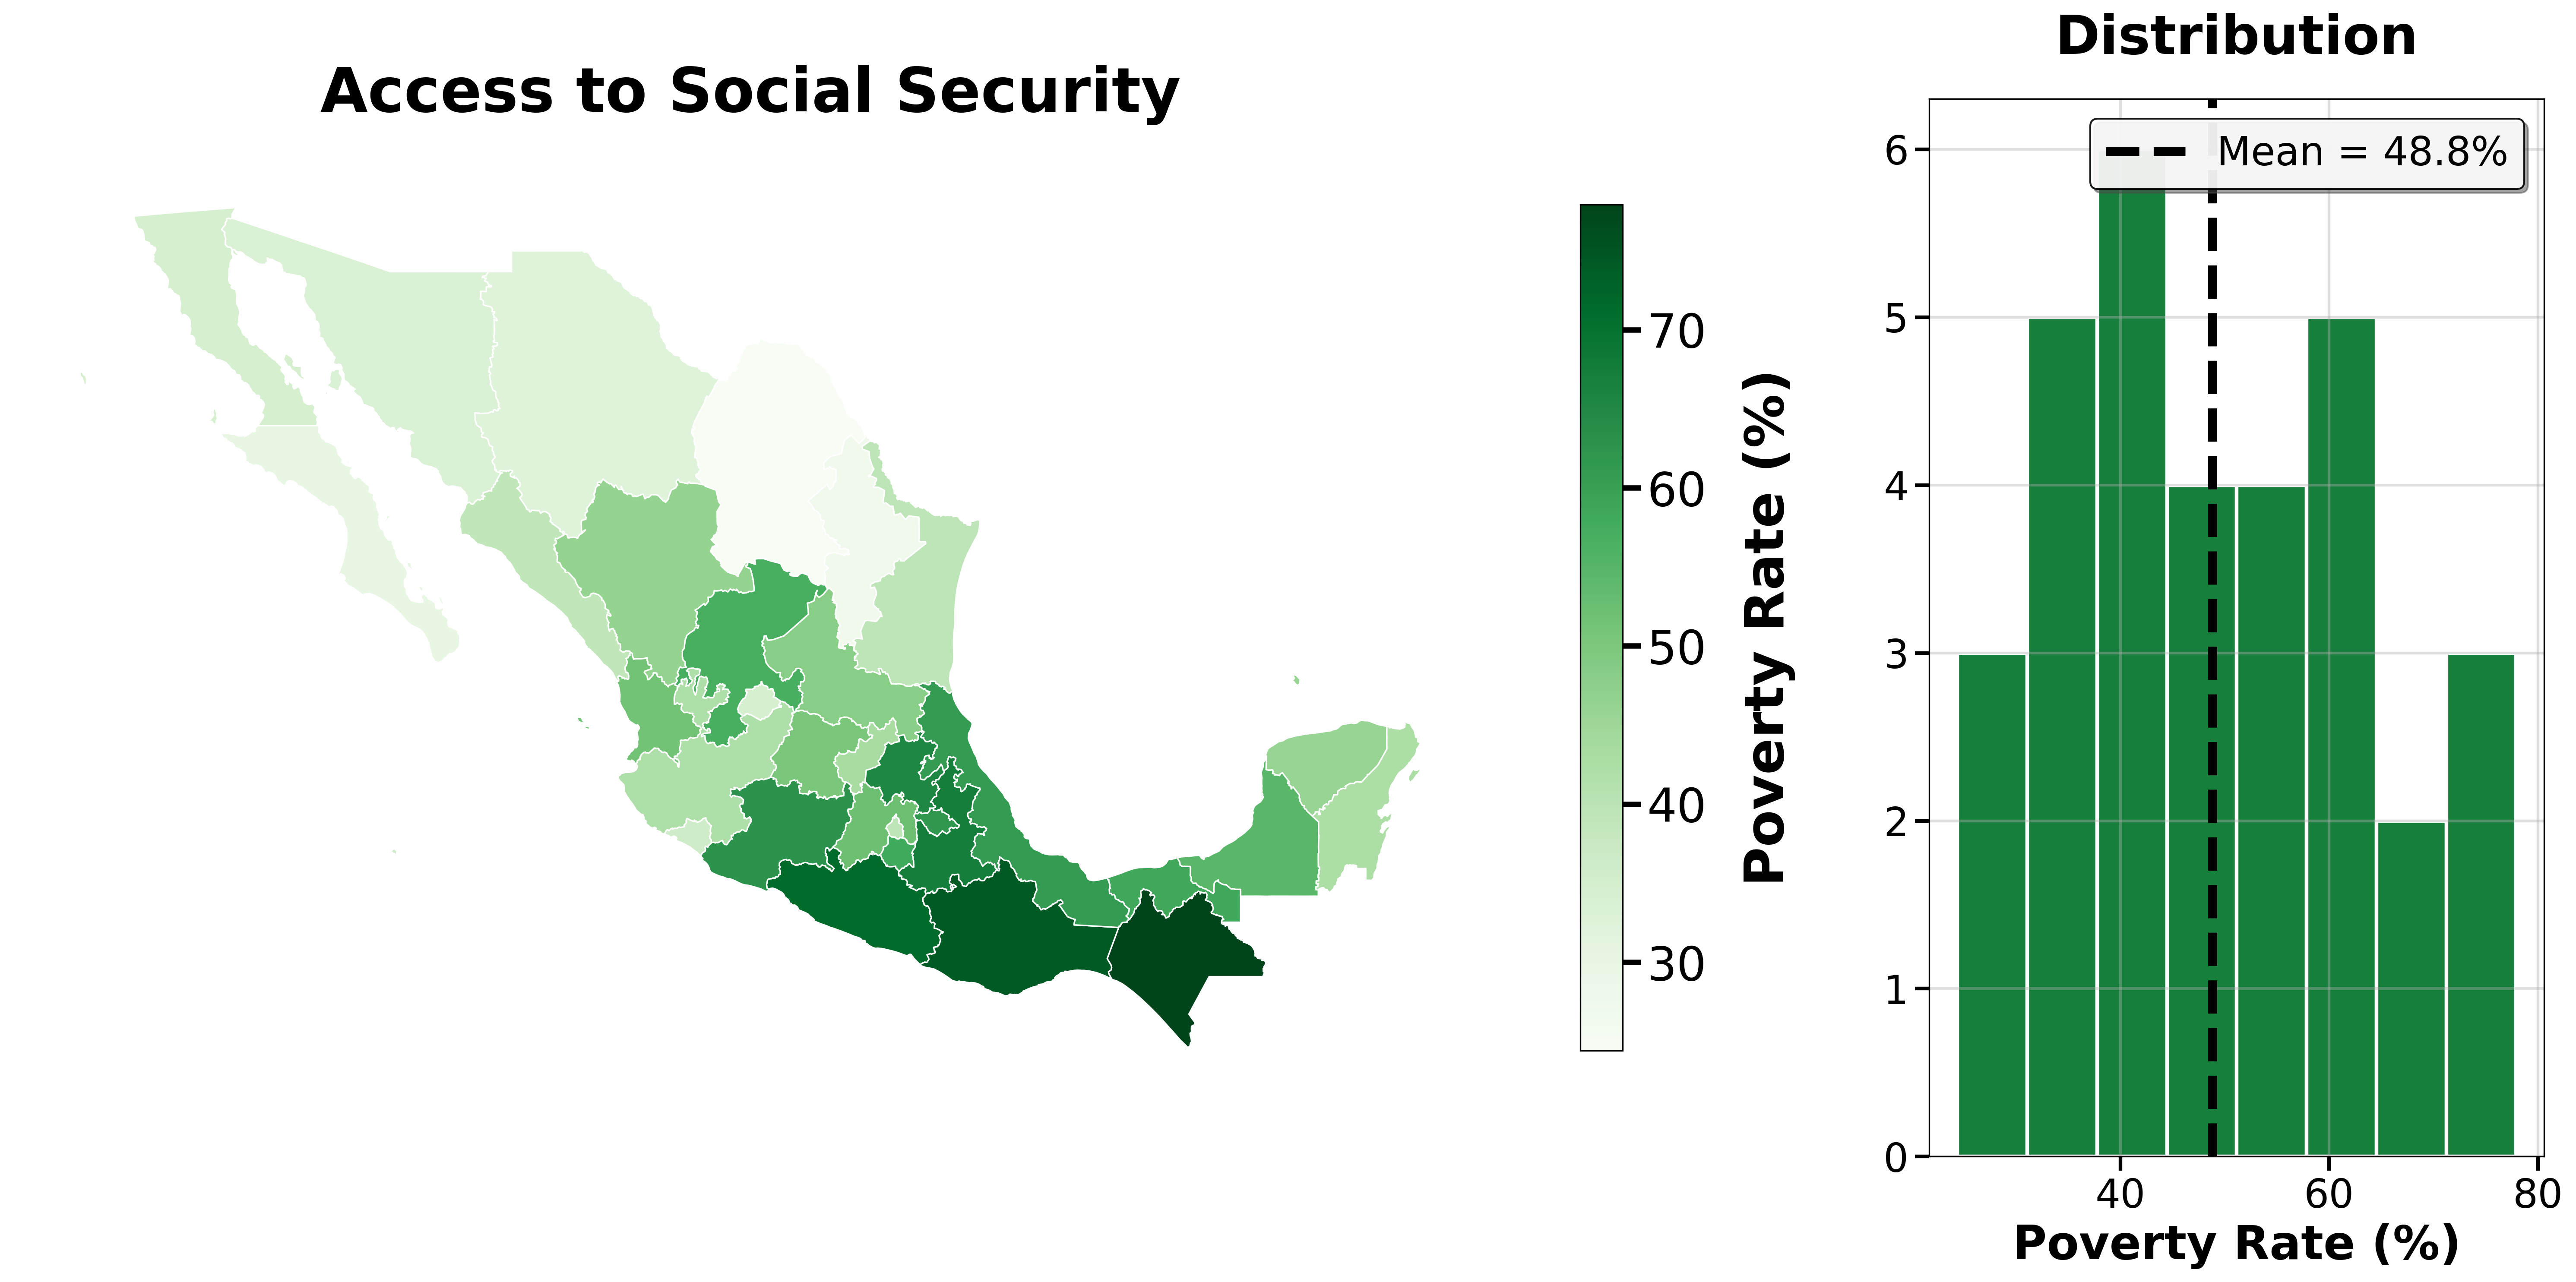

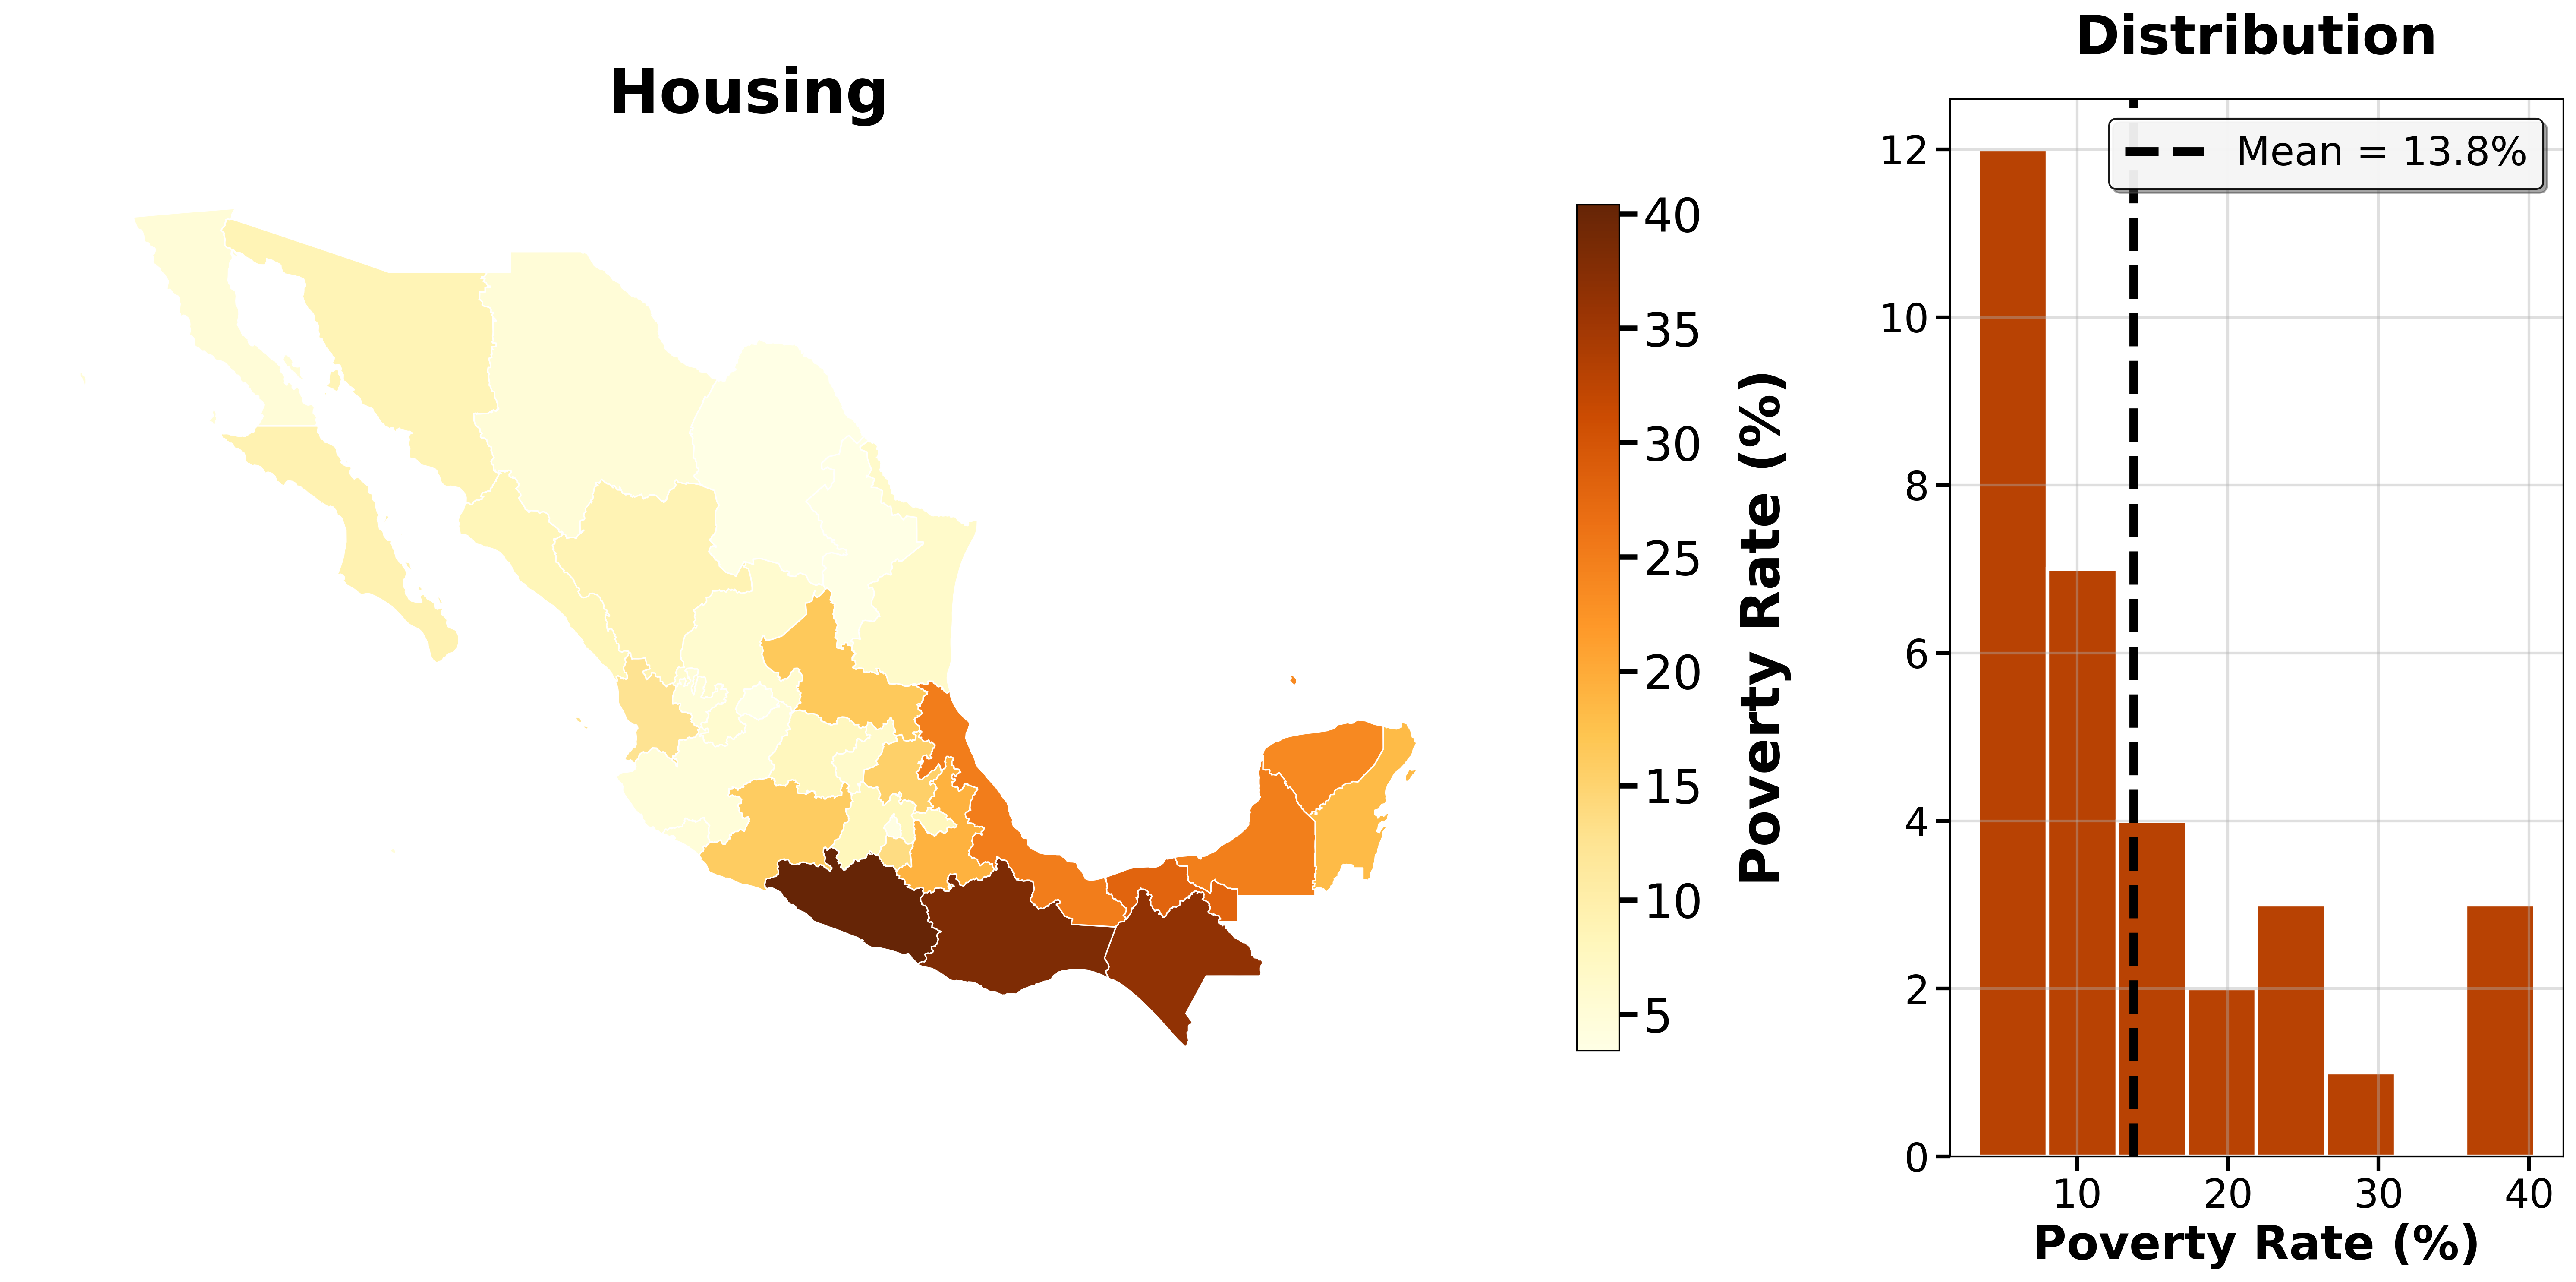

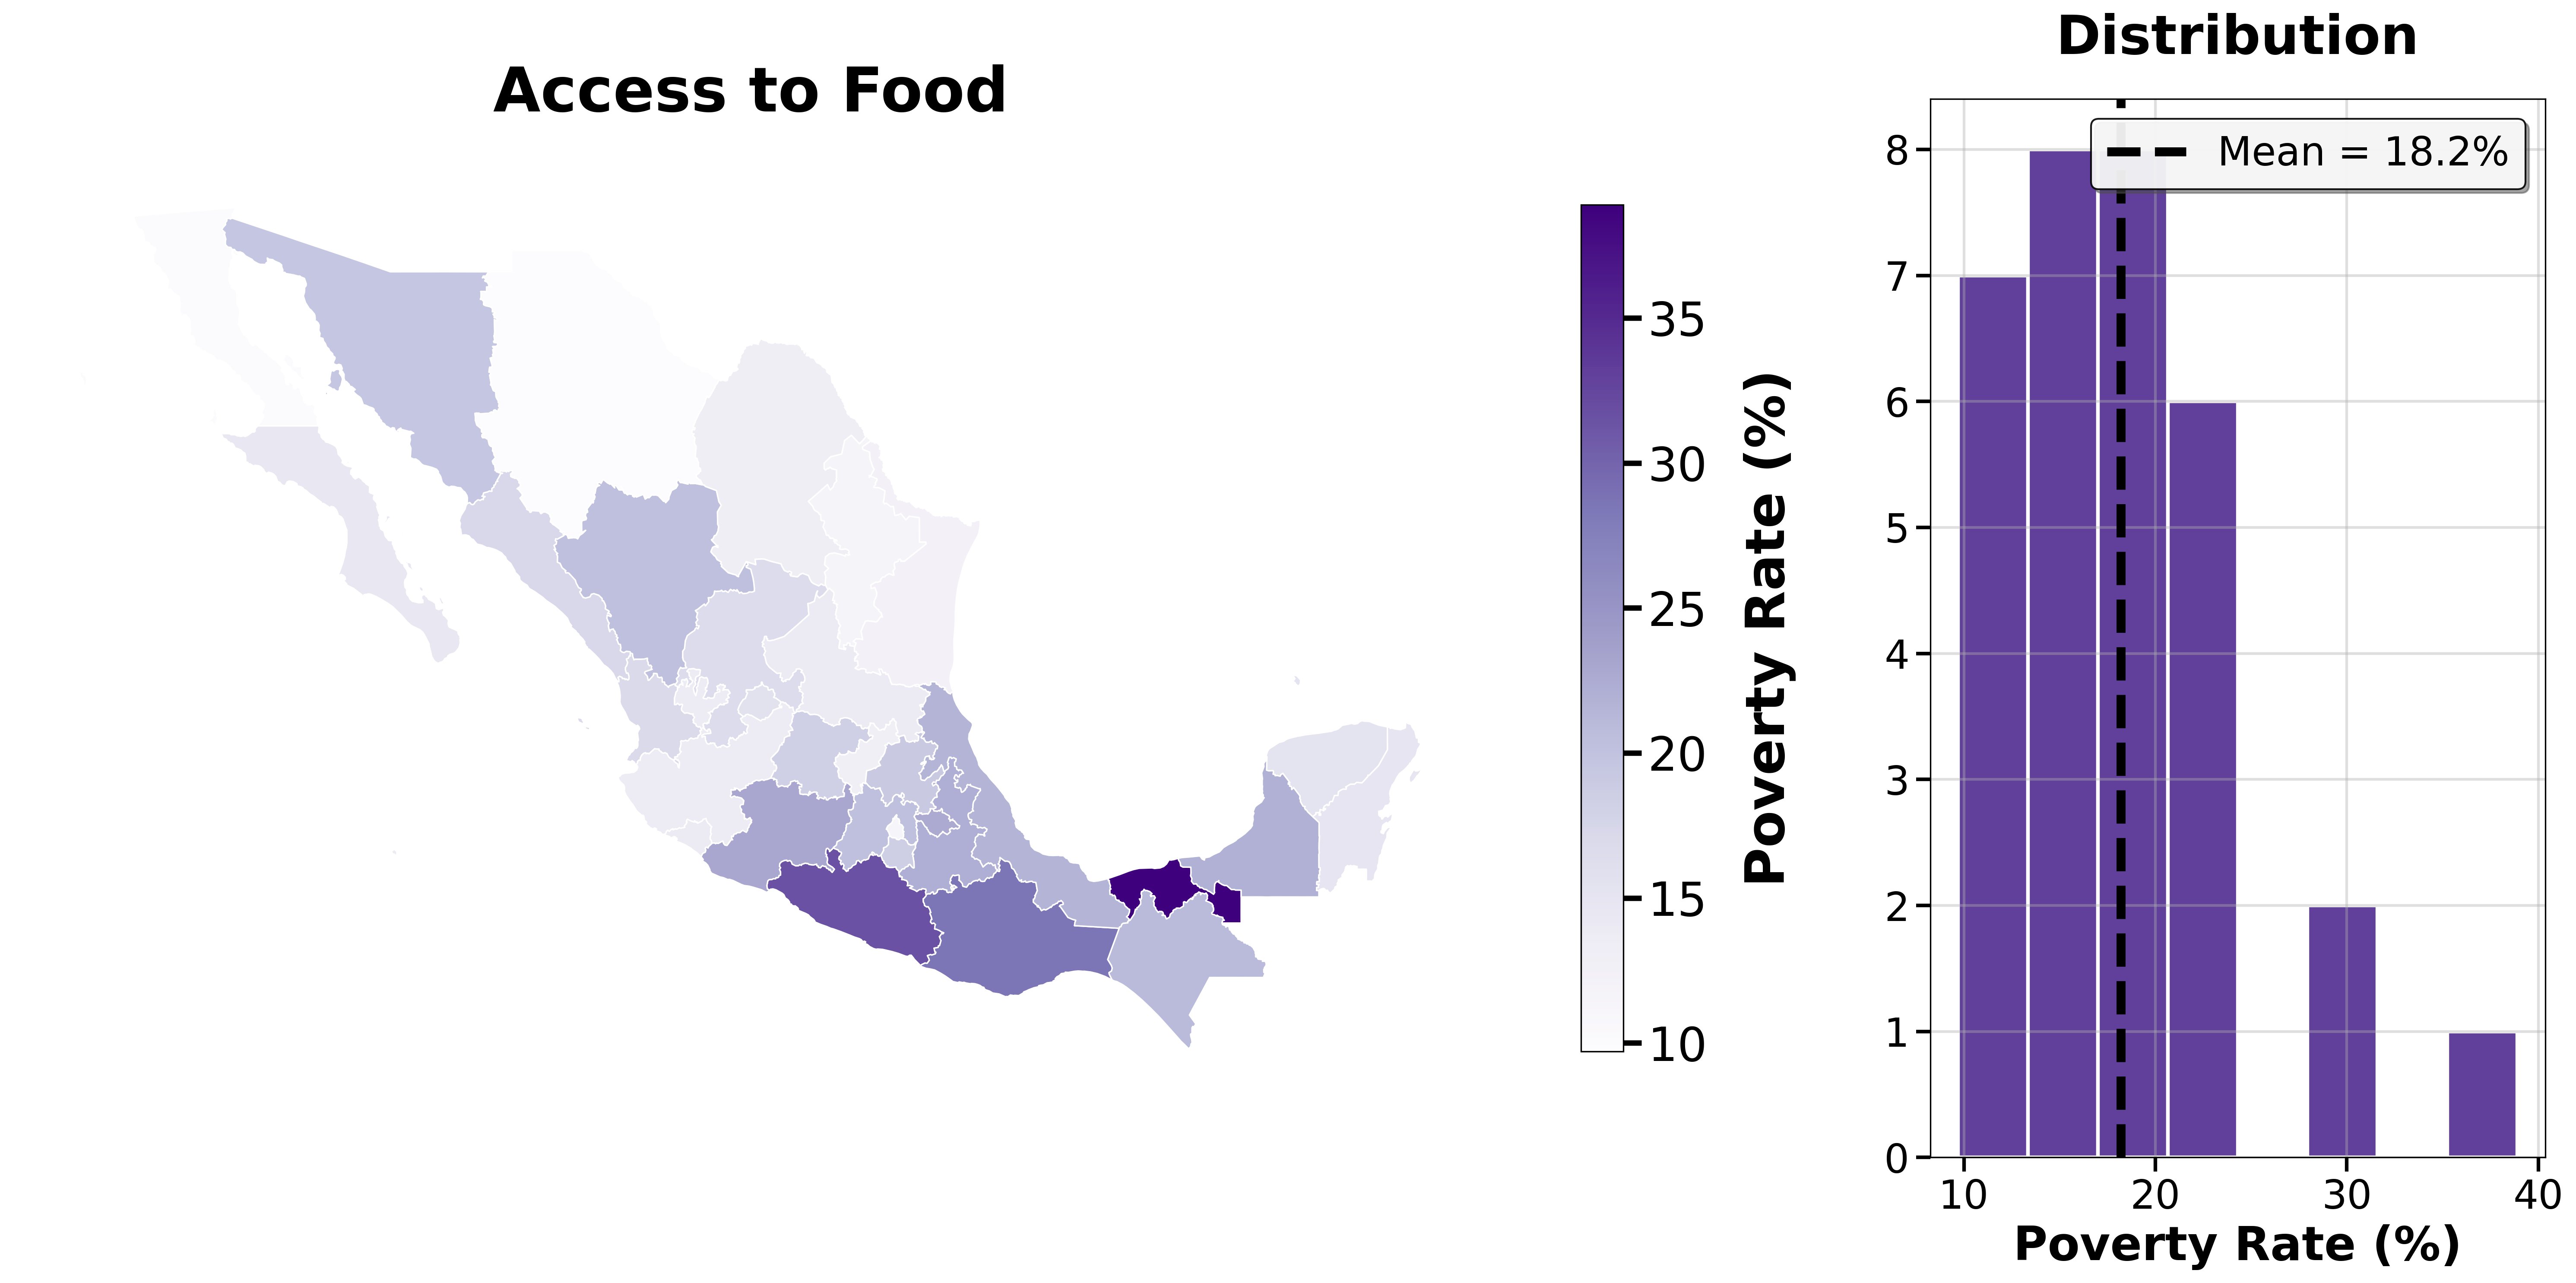

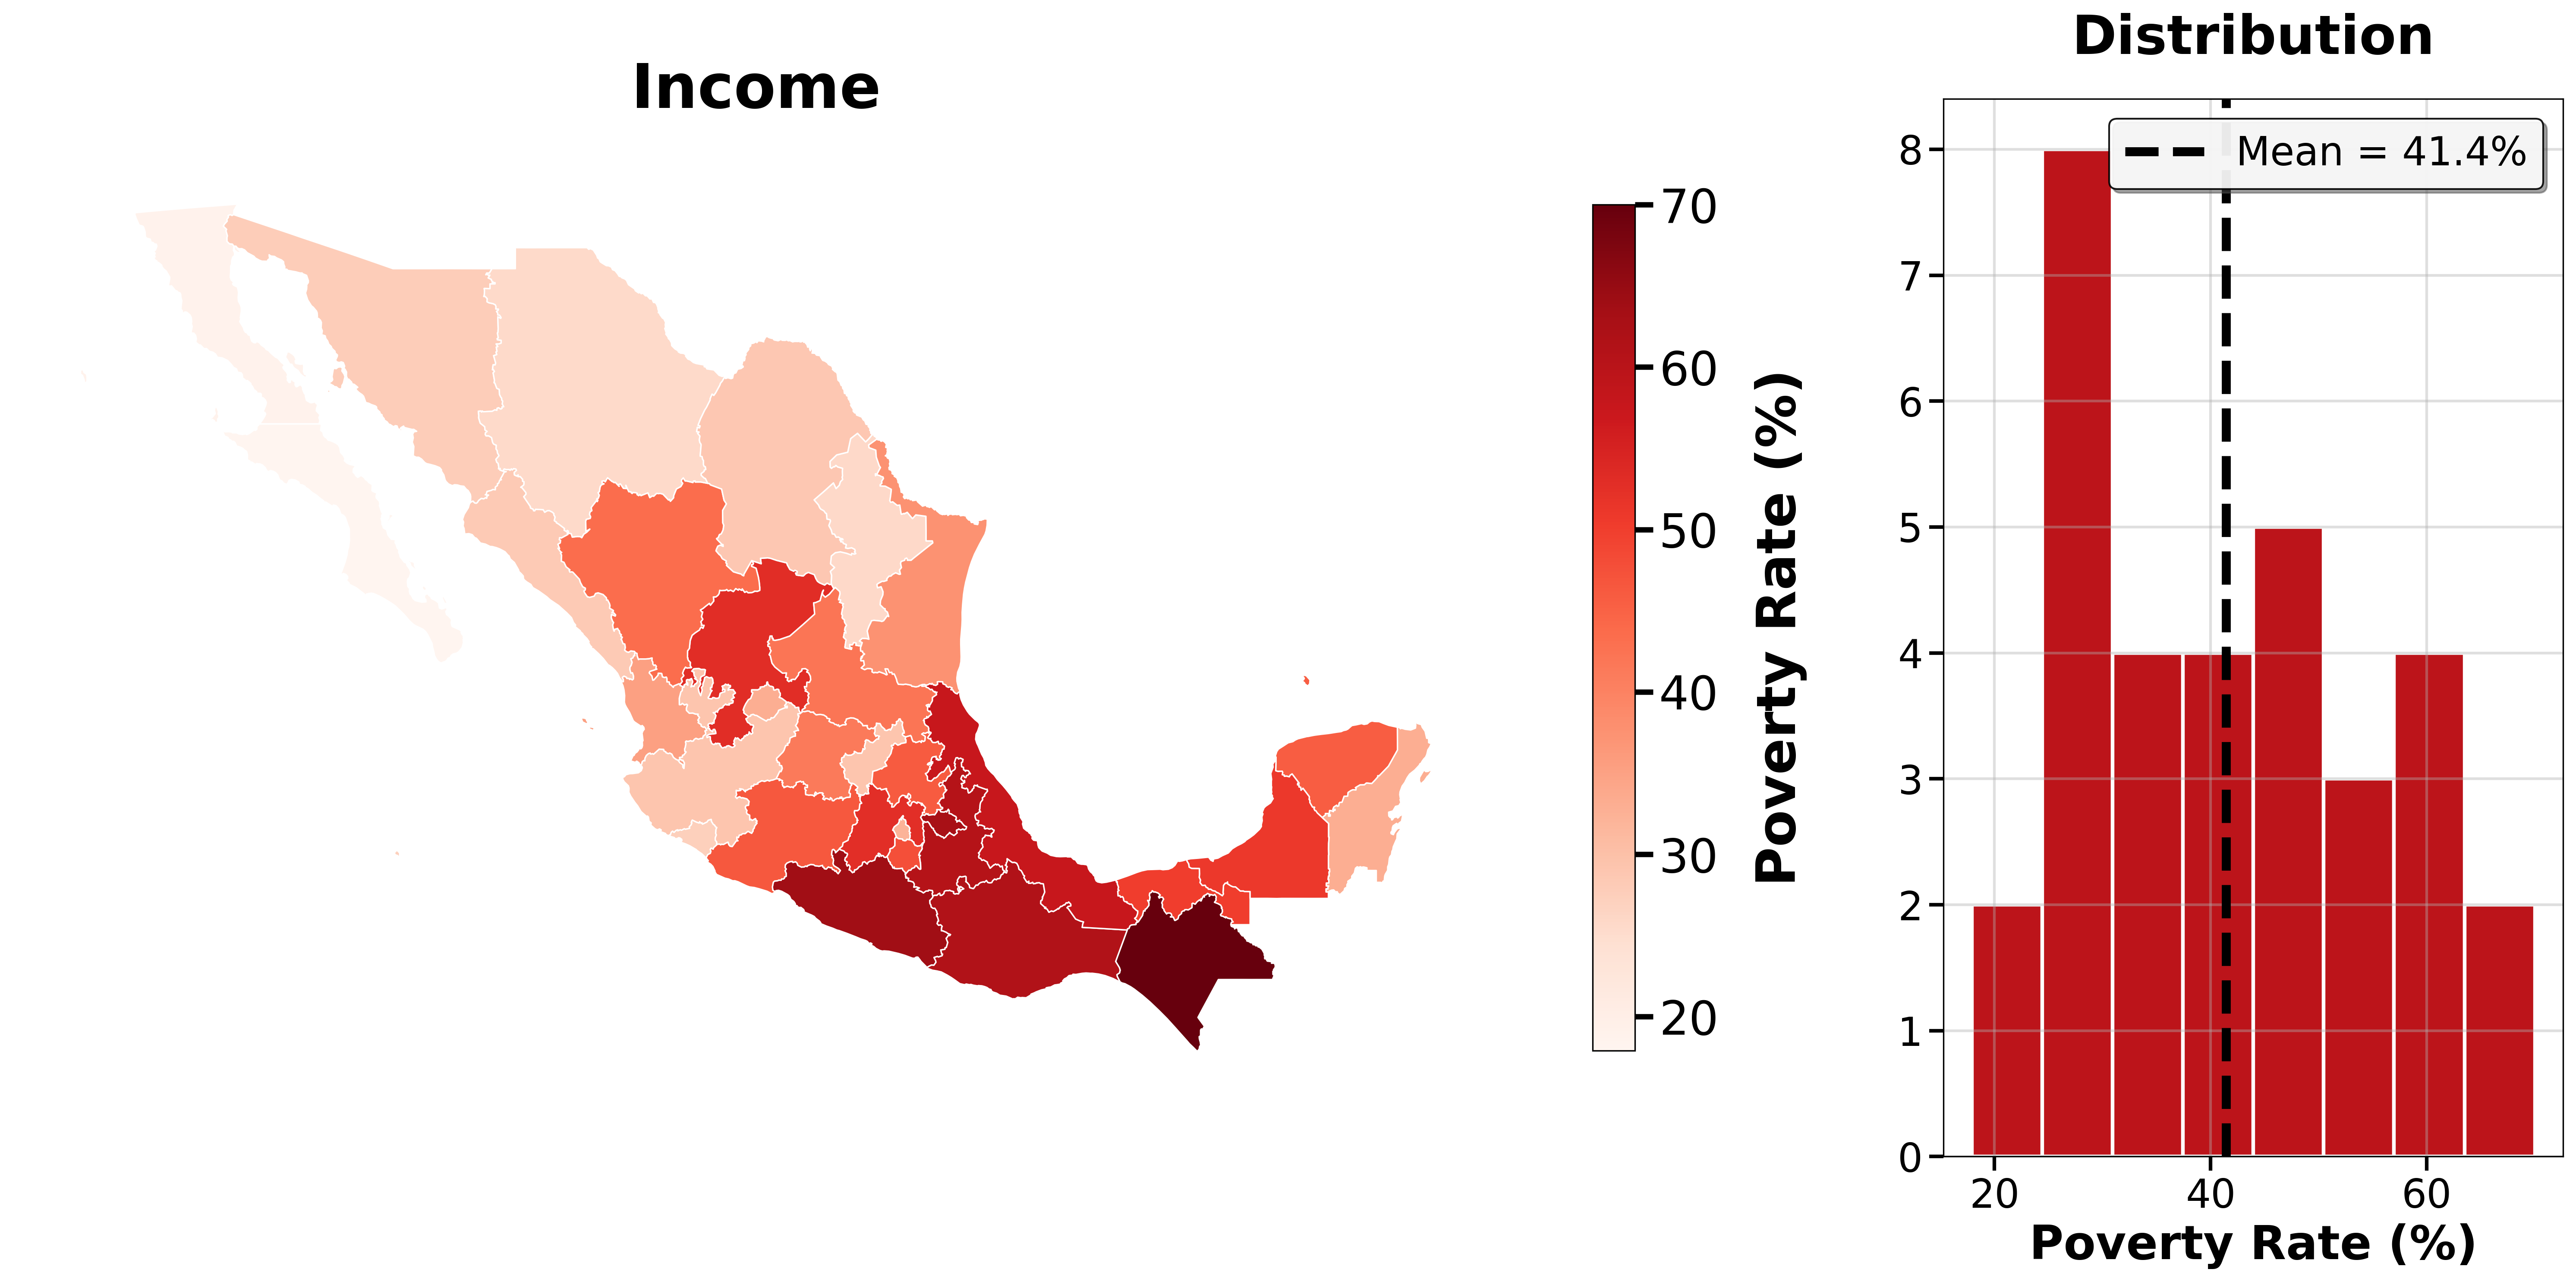

In [6]:
# assign standard colormaps to each dimension
dimension_colormaps = {
    'income_target': 'Reds',        
    'health_target': 'YlGnBu',       
    'social_target': 'Greens',      
    'housing_target': 'YlOrBr',   
    'food_target': 'Purples',     
    'educ_target': 'Blues'}

# standardize state names to match the GeoDataFrame
def standardize_state_names_data(df, state_col='state'):
    state_mapping = {
        'Ciudad de México': 'Distrito Federal',
        'Estado de México': 'México',
        'Michoacán': 'Michoacán de Ocampo',
        'Veracruz': 'Veracruz de Ignacio de la Llave',
        'Coahuila': 'Coahuila de Zaragoza',
        'Coahuila de Zaragoza': 'Coahuila de Zaragoza'}
    df[state_col] = df[state_col].replace(state_mapping)
    return df

# plot a single poverty map with distribution histogram
def plot_single_poverty_map_with_distribution(df, mx_states, dim_col, title, cmap_name):
    data = pd.DataFrame({
        'region': df['state'],
        'value': df[dim_col]})

    mx_states_merged = mx_states.merge(
        data,
        left_on="state_name",
        right_on="region",
        how="left")

    # define colormap and main color for histogram
    cmap_obj = plt.get_cmap(cmap_name)
    main_color = mcolors.to_hex(cmap_obj(0.8)) 

    fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=300, gridspec_kw={'width_ratios': [3, 1]})

    # create the map
    map_plot = mx_states_merged.plot(
        column="value",
        cmap=cmap_name,
        linewidth=0.8,
        edgecolor="white",
        legend=True,
        ax=axes[0],
        missing_kwds={"color": "lightgray", "edgecolor": "white", "linewidth": 0.5},
        legend_kwds={'label': 'Poverty Rate (%)', 'shrink': 0.8})

    # define labels and ticks
    cbar = map_plot.get_figure().axes[-1]
    cbar.tick_params(labelsize=26, width=3, length=10)  
    cbar.set_ylabel("Poverty Rate (%)", fontsize=30, weight='bold', labelpad=20)  

    axes[0].set_axis_off()
    axes[0].set_title(title, fontsize=34, fontweight='bold', pad=30)  

    # histogram on the right
    values = df[dim_col].dropna()
    axes[1].hist(values, bins=8, color=main_color, edgecolor='white', linewidth=2) 
    mean_val = values.mean()
    axes[1].axvline(mean_val, color='black', linestyle='--', linewidth=5, 
                   label=f'Mean = {mean_val:.1f}%')  

    axes[1].set_title("Distribution", fontsize=30, fontweight='bold', pad=25)  
    axes[1].set_xlabel("Poverty Rate (%)", fontsize=26, fontweight='bold') 
    axes[1].tick_params(axis='x', labelsize=22, width=2, length=8) 
    axes[1].tick_params(axis='y', labelsize=22, width=2, length=8)  
    axes[1].legend(fontsize=22, frameon=True, fancybox=True, shadow=True, 
                  loc='upper right', framealpha=0.9, edgecolor='black')  

    axes[1].grid(True, alpha=0.4, linewidth=1.5) 

    plt.tight_layout()
    filename = f"plots/{dim_col}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

# do the same for all poverty dimensions separately
def plot_poverty_maps_separately(off_2022: pd.DataFrame, mx_states: gpd.GeoDataFrame):
    dimension_labels = {
        'educ_target': 'Educational Lag',
        'health_target': 'Access to Health Services',
        'social_target': 'Access to Social Security',
        'housing_target': 'Housing',
        'food_target': 'Access to Food',
        'income_target': 'Income'}

    off_data = standardize_state_names_data(off_2022.copy())

    for dim_col, title in dimension_labels.items():
        cmap = dimension_colormaps[dim_col]
        plot_single_poverty_map_with_distribution(
            df=off_data,
            mx_states=mx_states,
            dim_col=dim_col,
            title=title,
            cmap_name=cmap)

plot_poverty_maps_separately(off_2022, mx_states)

# in-sample and out-of-sample MAE

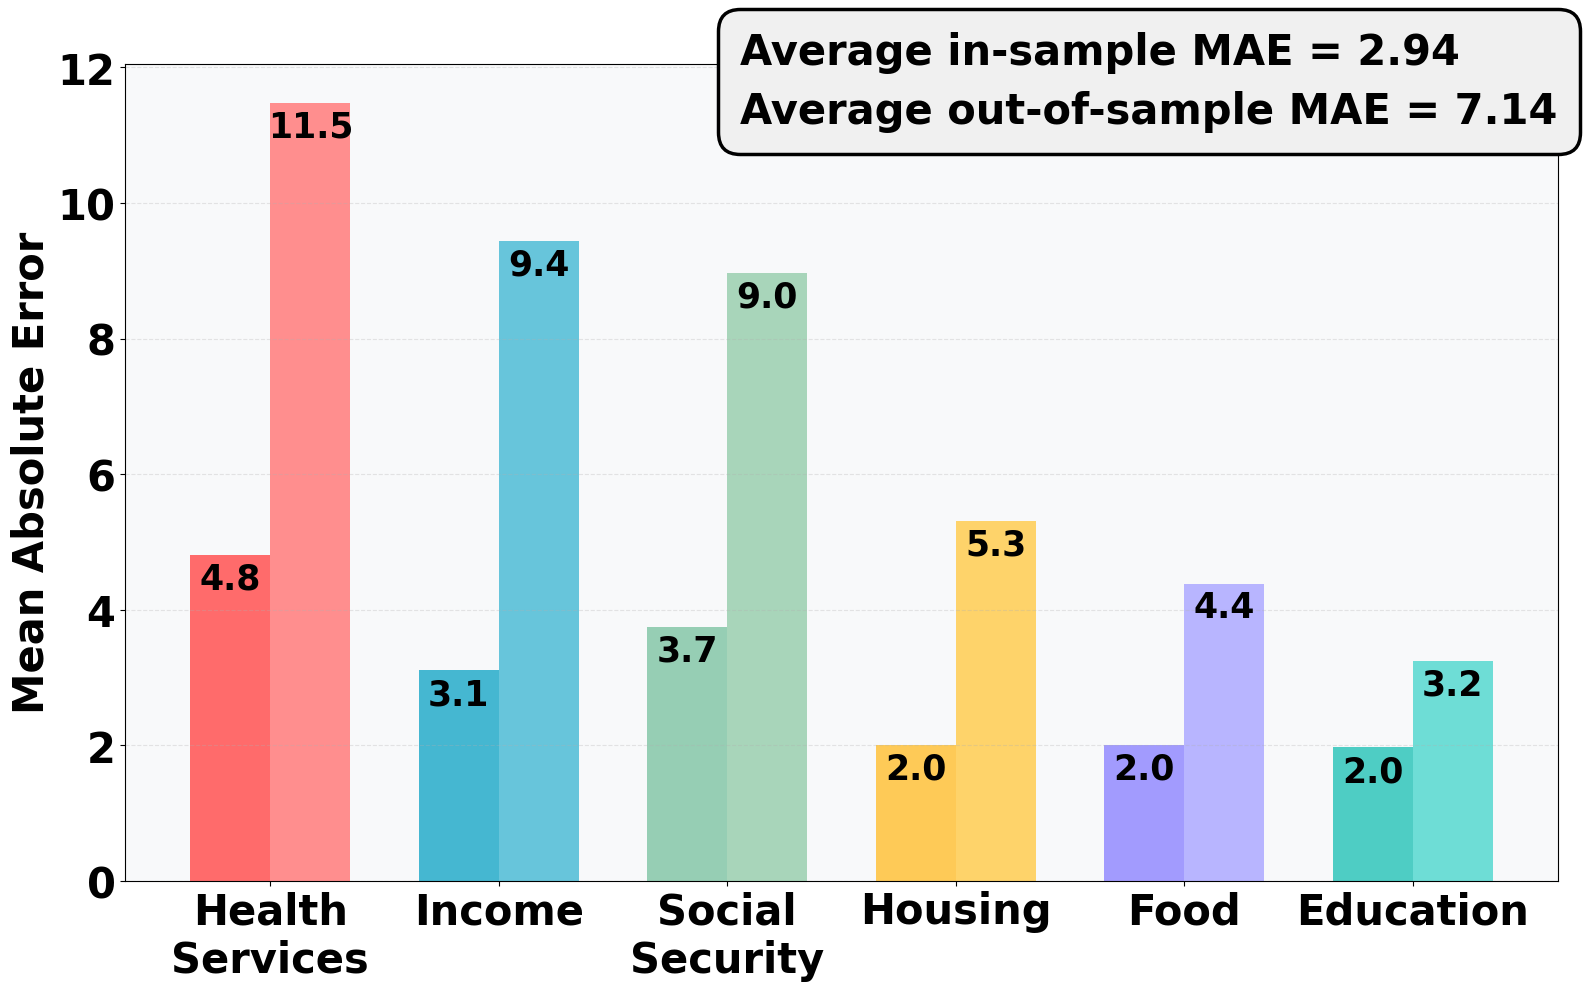

In [3]:
# create a dual bar chart comparing in-sample and out-of-sample MAE per dimension
def create_dual_bars(mae_in_sample, mae_out_sample):
    fig, ax = plt.subplots(figsize=(16, 10))  

    # merge the two DataFrames on dimension and prepare the data
    merged = mae_in_sample.copy().rename(columns={'mae': 'mae_in'})
    merged['mae_out'] = mae_out_sample['mae']
    merged['mae_max'] = merged[['mae_in', 'mae_out']].max(axis=1)  # Used for sorting
    merged = merged.sort_values('mae_max', ascending=False)

    # rename 'health' to 'health services' for consistency with other plots
    merged['dimension'] = merged['dimension'].replace({'health': 'health services'})
    
    # extract data for plotting
    dimensions = merged['dimension'].values
    mae_in = merged['mae_in'].values
    mae_out = merged['mae_out'].values
    x = np.arange(len(dimensions))
    width = 0.35  # Width of each bar

    # define custom color palettes for in-sample and out-of-sample bars
    base_colors_in = ['#FF6B6B', '#45B7D1', '#96CEB4', '#FECA57', '#A29BFE', '#4ECDC4']
    base_colors_out = ['#FF8E8E', '#67C5DB', '#A8D5BA', '#FED36A', '#B8B5FF', '#6EDDD6']
    colors_in = (base_colors_in * ((len(dimensions) + 5) // 6))[:len(dimensions)]
    colors_out = (base_colors_out * ((len(dimensions) + 5) // 6))[:len(dimensions)]

    # plot the bars for in-sample and out-of-sample MAEs
    bars1 = ax.bar(x - width/2, mae_in, width, color=colors_in, alpha=1)
    bars2 = ax.bar(x + width/2, mae_out, width, color=colors_out, alpha=1)

    ax.set_facecolor('#f8f9fa')  

    # annotate each bar with the MAE value 
    for bar1, bar2 in zip(bars1, bars2):
        ax.annotate(f'{bar1.get_height():.1f}',
                    xy=(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() - 0.1),
                    ha='center', va='top', fontweight='bold', fontsize=25, color='black')
        ax.annotate(f'{bar2.get_height():.1f}',
                    xy=(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() - 0.1),
                    ha='center', va='top', fontweight='bold', fontsize=25, color='black')

    # axis label
    ax.set_ylabel('Mean Absolute Error', fontsize=30, fontweight='bold')

    # format x-axis labels with line breaks
    formatted_labels = []
    for d in dimensions:
        clean_label = d.replace('_', ' ').title()
        if ' ' in clean_label:
            parts = clean_label.split()
            clean_label = parts[0] + '\n' + ' '.join(parts[1:])
        formatted_labels.append(clean_label)

    ax.set_xticks(x)
    ax.set_xticklabels(formatted_labels, rotation=0, ha='center', fontsize=35, fontweight='bold')

    ax.tick_params(axis='both', which='major', labelsize=30)
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    ax.grid(axis='y', alpha=0.3, linestyle='--')  

    # Add a summary box in the top right corner with average MAEs
    mae_in_mean = mae_in.mean()
    mae_out_mean = mae_out.mean()

    box_text = (
        f"Average in-sample MAE = {mae_in_mean:.2f}\n"
        f"Average out-of-sample MAE = {mae_out_mean:.2f}")

    text_area = TextArea(box_text, textprops=dict(
        fontsize=30,
        fontweight='bold',
        color='black',
        linespacing=1.5))

    ab = AnnotationBbox(
        text_area,
        xy=(1.0, 1.04),  # Position in top-right corner of the axes
        xycoords='axes fraction',
        box_alignment=(1, 1),
        bboxprops=dict(
            facecolor='#f0f0f0',
            edgecolor='black',
            boxstyle='round,pad=1.6',
            linewidth=2.5
        )
    )
    ax.add_artist(ab)

    plt.tight_layout()
    return fig

fig = create_dual_bars(mae_in_sample, mae_out_sample)
fig.savefig('plots/mae_bars.png', dpi=300, bbox_inches='tight', facecolor='white')

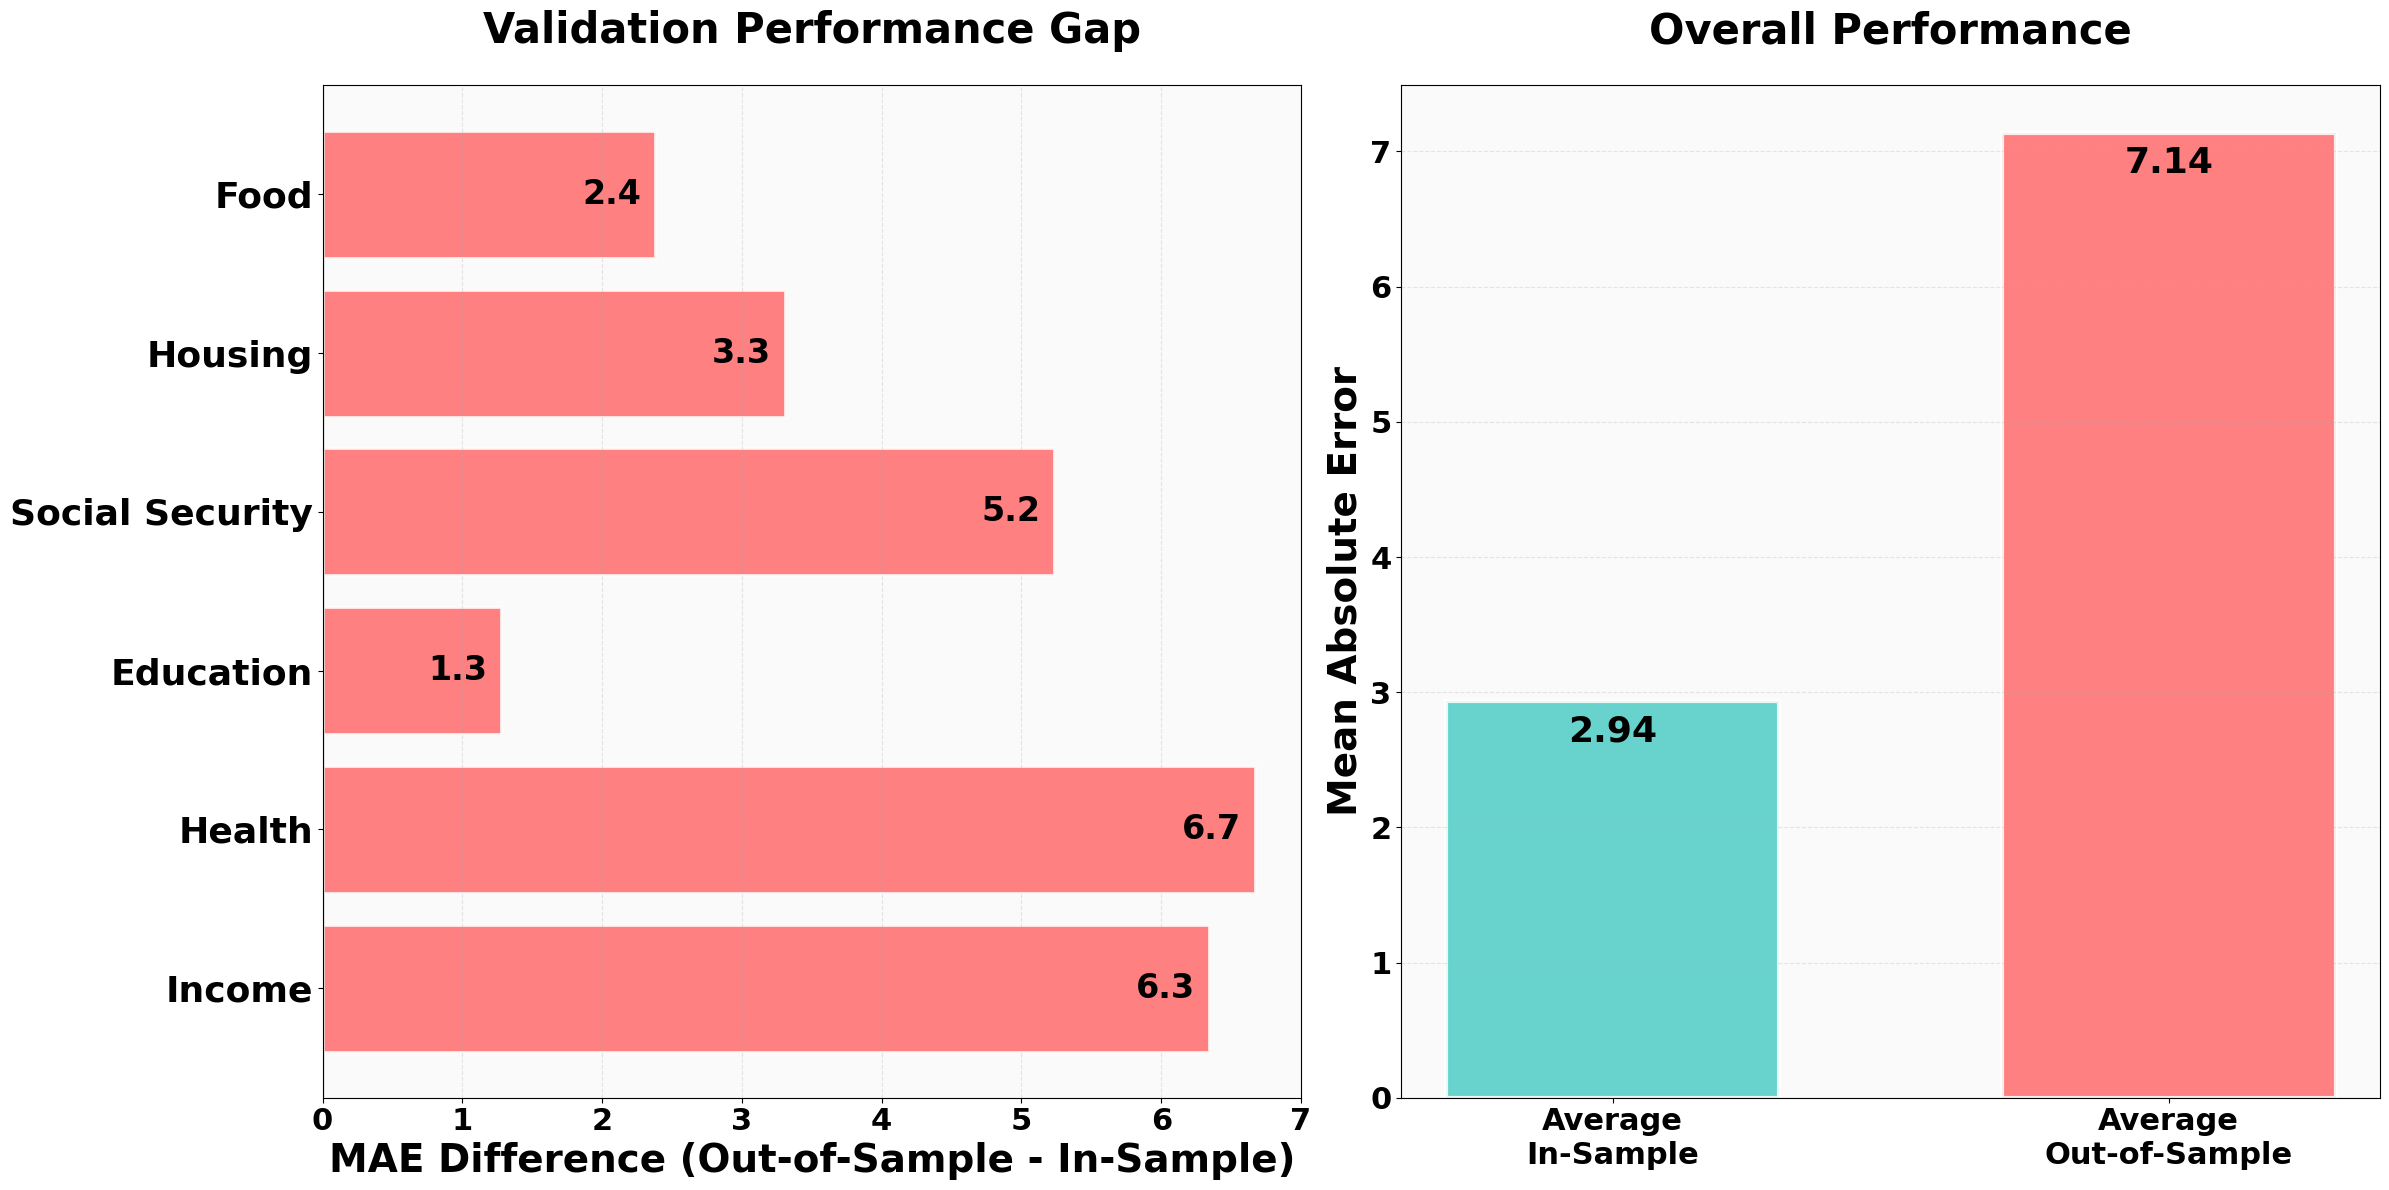

In [4]:
def create_mae_comparison(mae_in_sample, mae_out_sample):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))  
    
    dimensions = [d.replace('_', ' ').title() for d in mae_in_sample['dimension'].values]
    mae_in = mae_in_sample['mae'].values
    mae_out = mae_out_sample['mae'].values

    # 1) Generalization gap
    difference = mae_out - mae_in
    colors = ['#ff6b6b' if x > 0 else '#51cf66' for x in difference]
    
    bars1 = ax1.barh(range(len(dimensions)), difference, color=colors, alpha=0.85, 
                     edgecolor='white', linewidth=2)
    
    ax1.set_yticks(range(len(dimensions)))
    ax1.set_yticklabels(dimensions, fontsize=26, fontweight='bold')
    ax1.set_xlabel('MAE Difference (Out-of-Sample - In-Sample)', fontsize=28, fontweight='bold')
    ax1.set_title('Validation Performance Gap', fontsize=30, fontweight='bold', pad=30)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    ax1.set_facecolor('#fafafa')
    ax1.tick_params(axis='x', labelsize=22)

    for bar, val in zip(bars1, difference):
        width = bar.get_width()
        y_center = bar.get_y() + bar.get_height() / 2

        if abs(val) < 0.5:
            # label outisde the bar if the value is small
            ax1.annotate(f'{val:.1f}',
                         xy=(width, y_center),
                         xytext=(12 if width >= 0 else -12, 0),
                         textcoords="offset points",
                         ha='left' if width >= 0 else 'right',
                         va='center',
                         fontsize=24, fontweight='bold', color='black')
        else:
            # label inside the bar if the value is large
            ax1.annotate(f'{val:.1f}',
                         xy=(width - 0.1 if width >= 0 else width + 0.1, y_center),
                         ha='right' if width >= 0 else 'left',
                         va='center',
                         fontsize=24, fontweight='bold', color='black')

    # 2) Overall Performance
    avg_mae_in = mae_in.mean()
    avg_mae_out = mae_out.mean()

    categories = ['Average\nIn-Sample', 'Average\nOut-of-Sample']
    values = [avg_mae_in, avg_mae_out]
    colors_summary = ['#4ecdc4', '#ff6b6b']
    
    bars2 = ax2.bar(categories, values, color=colors_summary, alpha=0.85, 
                    edgecolor='white', linewidth=3, width=0.6)

    for bar, val in zip(bars2, values):
        ax2.annotate(f'{val:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, val - 0.1),
                     ha='center', va='top',
                     fontsize=26, fontweight='bold', color='black')

    ax2.set_ylabel('Mean Absolute Error', fontsize=28, fontweight='bold')
    ax2.set_title('Overall Performance', fontsize=30, fontweight='bold', pad=30)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_facecolor('#fafafa')
    ax2.tick_params(axis='x', labelsize=22)
    ax2.tick_params(axis='y', labelsize=22)

    # ticks in bold
    for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')

    fig.patch.set_facecolor('#ffffff')
    plt.tight_layout()
    return fig

mae_comp = create_mae_comparison(mae_in_sample, mae_out_sample)
mae_comp.savefig('plots/mae_analysis.png', dpi=300, bbox_inches='tight')

# PCA for social cohesion

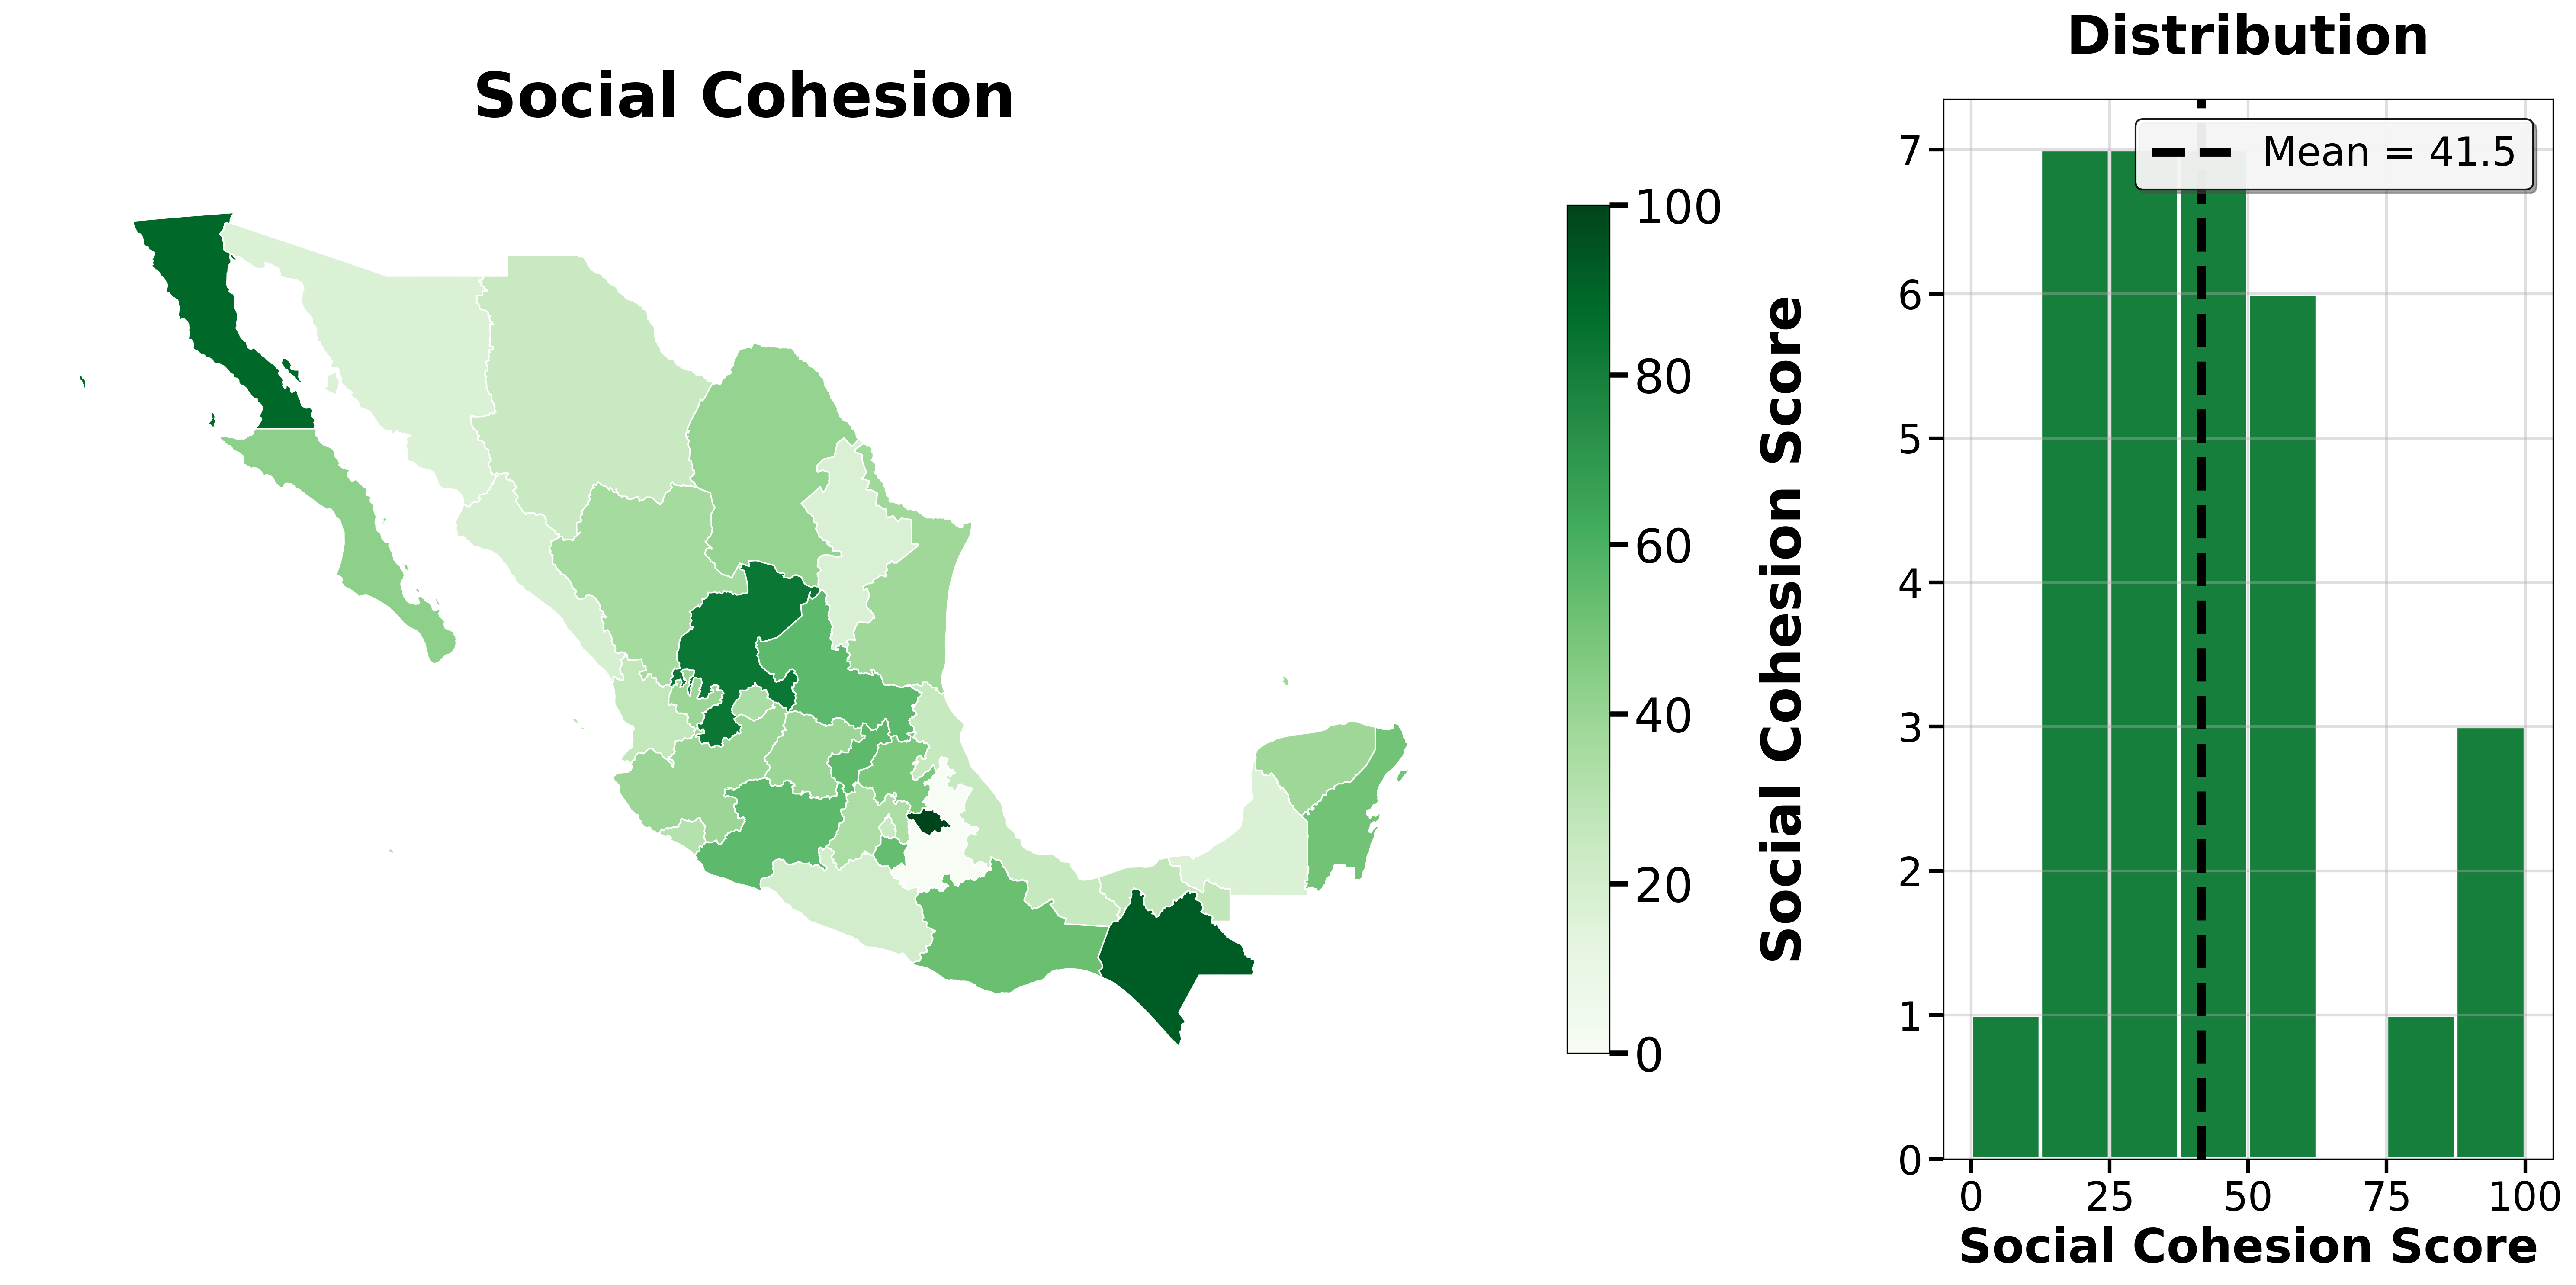

In [7]:
# plot a map and histogram of the social cohesion dimension
def plot_social_pca_map_with_distribution(pca_social_df: pd.DataFrame, mx_states: gpd.GeoDataFrame):
    # Standardize state names in the PCA data for correct merging with GeoDataFrame
    df = standardize_state_names_data(pca_social_df.copy())
    df = df.rename(columns={'social_cohesion_score': 'value'})  # Rename for consistency with mapping function

    # merge PCA scores with the Mexican states shapefile
    mx_states_merged = mx_states.merge(
        df,
        left_on="state_name",
        right_on="state",
        how="left")

    # choose color palette for the map
    cmap_name = 'Greens'
    cmap_obj = plt.get_cmap(cmap_name)
    main_color = mcolors.to_hex(cmap_obj(0.8))  # Select a shade from the colormap for histogram

    # create a figure with two subplots: map and histogram
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=300, gridspec_kw={'width_ratios': [3, 1]})

    # map showing social cohesion score by state
    map_plot = mx_states_merged.plot(
        column="value",
        cmap=cmap_name,
        linewidth=0.8,
        edgecolor="white",
        legend=True,
        ax=axes[0],
        missing_kwds={"color": "lightgray", "edgecolor": "white", "linewidth": 0.5},
        legend_kwds={'label': 'Score', 'shrink': 0.8})

    # customize colorbar
    cbar = map_plot.get_figure().axes[-1]
    cbar.tick_params(labelsize=26, width=3, length=10)
    cbar.set_ylabel("Social Cohesion Score", fontsize=30, weight='bold', labelpad=20)

    axes[0].set_axis_off()
    axes[0].set_title("Social Cohesion", fontsize=34, fontweight='bold', pad=30)

    # histogram of social cohesion scores across states
    values = df['value'].dropna()
    axes[1].hist(values, bins=8, color=main_color, edgecolor='white', linewidth=2)

    # add mean line to the histogram
    mean_val = values.mean()
    axes[1].axvline(mean_val, color='black', linestyle='--', linewidth=5,
                    label=f'Mean = {mean_val:.1f}')

    axes[1].set_title("Distribution", fontsize=30, fontweight='bold', pad=25)
    axes[1].set_xlabel("Social Cohesion Score", fontsize=26, fontweight='bold')
    axes[1].tick_params(axis='x', labelsize=22, width=2, length=8)
    axes[1].tick_params(axis='y', labelsize=22, width=2, length=8)

    # add legend for the mean line
    axes[1].legend(fontsize=22, frameon=True, fancybox=True, shadow=True,
                   loc='upper right', framealpha=0.9, edgecolor='black')
    axes[1].grid(True, alpha=0.4, linewidth=1.5)

    plt.tight_layout() 
    plt.savefig("plots/social_pca_score.png", dpi=300, bbox_inches='tight') 

plot_social_pca_map_with_distribution(pca_social, mx_states)